# Load dependencies
- Change oversample indices

In [1]:
import os
os.getcwd()
os.chdir('/tf/notebooks/ruez/stroke_bern')

In [2]:
!pip install tabulate

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# from PIL import Image
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
# from scipy import ndimage
from scipy import ndimage
from scipy.special import expit, logit

from skimage import exposure
import sklearn.metrics as skm
from tabulate import tabulate

# Tensorflow/Keras
import tensorflow as tf
print(tf.__version__) #2.4.0
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.utils import to_categorical
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Own functions
from functions.plot_slices import plot_slices
from functions.CNN_architecture import Conv2Plus1D
from functions.keras_training_progress import PlotLearning
# ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc, ontram_auc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters

from functions.augmentation3d import zoom, rotate, flip, shift

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-_do2lb64 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


2.4.0


In [4]:
# Define the path + output path:
# os.getcwd()
DIR = "/tf/notebooks/"
DATA_DIR = "ruez/stroke_bern/data/"
OUTPUT_DIR = "/tf/notebooks/ruez/stroke_bern/callbacks/ontrams_3d_resent_clinical_dwi/"

# Import images

In [5]:
with h5py.File(DIR + DATA_DIR + "data_bern_25_11_2020_preprocessed.h5", "r") as h5:
    X0 = h5["X_dwi"][:]
print(X0.shape, X0.min(), X0.max(), X0.mean(), X0.std()) # patients, coronal, sagittal, axial, channels

(222, 128, 128, 64, 1) -7.217837989522173 39.758812613731685 -3.158197493145928 1.8809703357091876


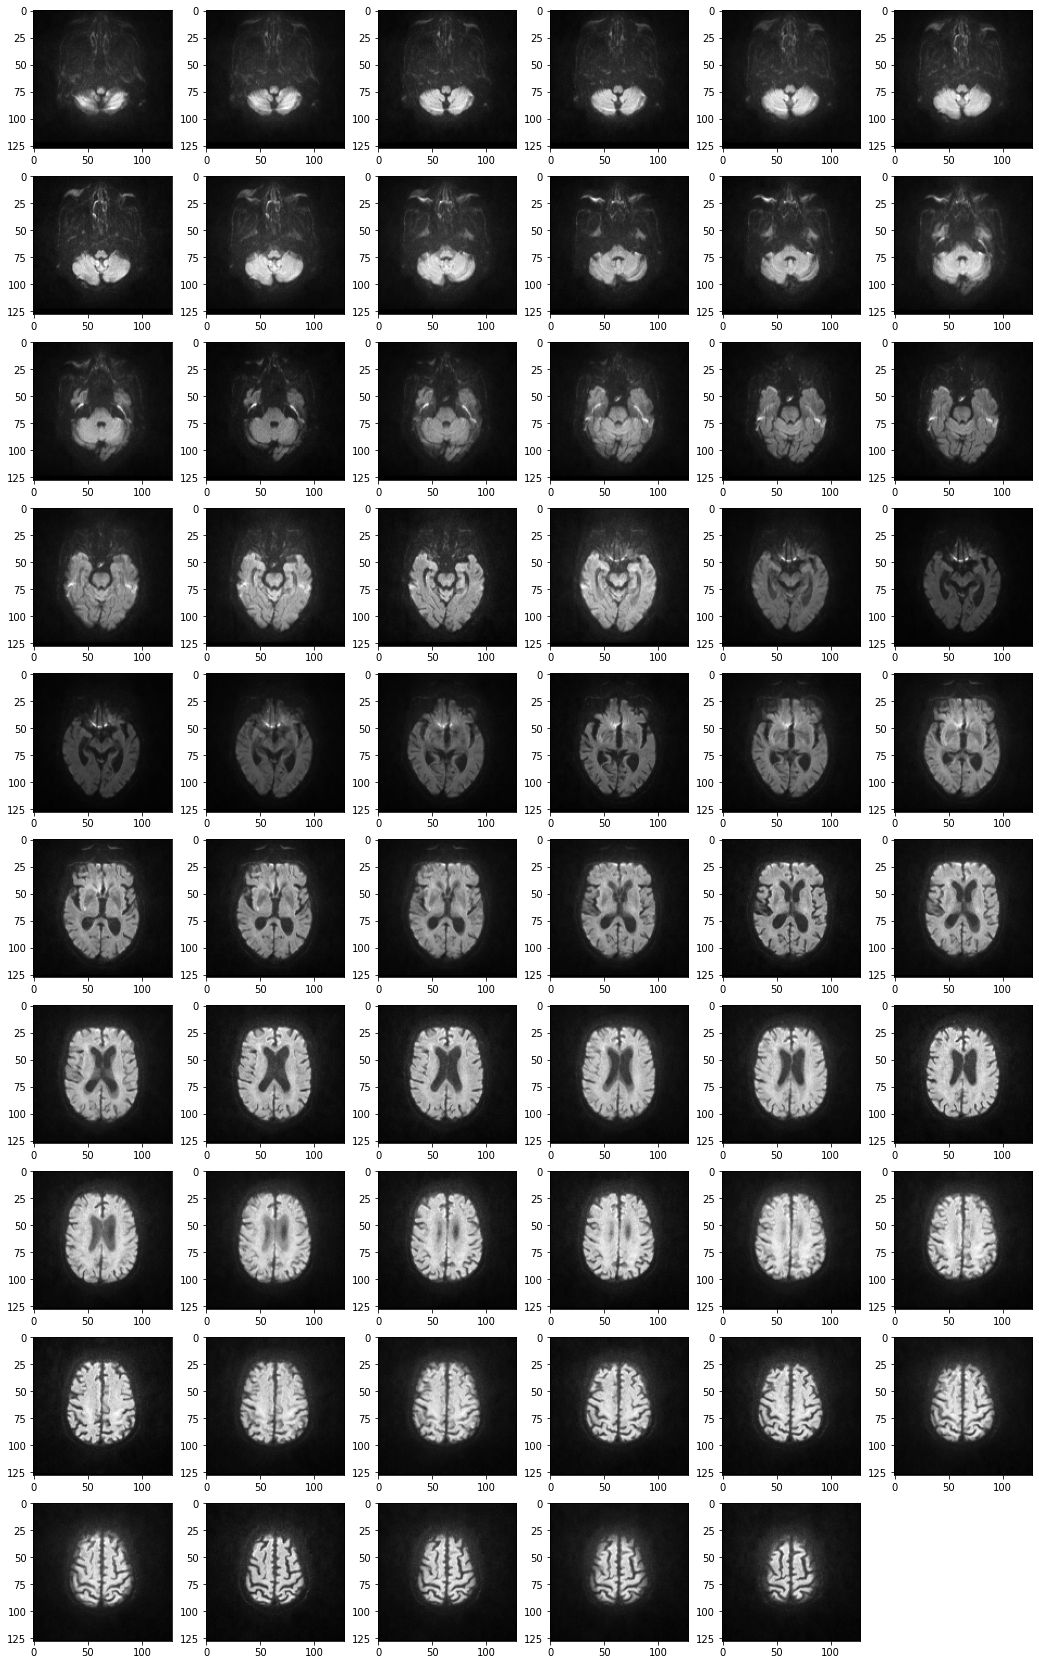

In [6]:
plot_slices(X0[0], 0, "axial", modality = "DWI") # e.g. patient 0

#### Reduce images per patient

In [6]:
# Reshape the data to reduce images per patient
print('old shape: ', X0[0].shape[:]) # original shape
dim = (128, 128, 20, 1) # target shape

X = np.empty((len(X0), 128, 128, 20, 3))
for i in range(len(X0)):
    scaling_factor = [dim[0]/X0[i].shape[0], dim[1]/X0[i].shape[1], dim[2]/X0[i].shape[2], dim[3]/X0[i].shape[3]]
    X[i,:,:,:,:] = ndimage.zoom(X0[i], scaling_factor, order = 1)
X[:,:,:,:,1] = X[:,:,:,:,0]
X[:,:,:,:,2] = X[:,:,:,:,0]
print('target shape: ', dim)

old shape:  (128, 128, 64, 1)
target shape:  (128, 128, 20, 1)


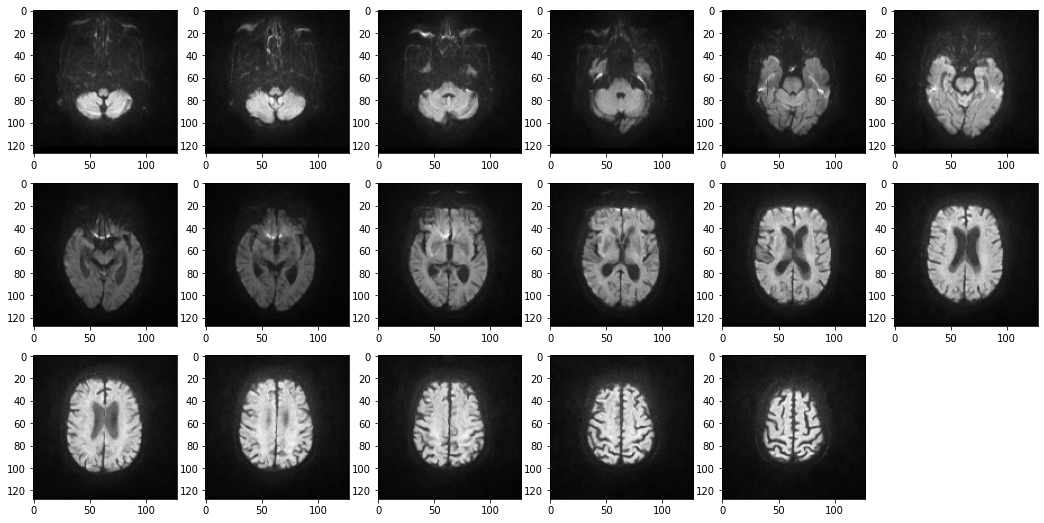

In [8]:
plot_slices(X[0], 0, "axial", "DWI")

# Import clinical and patient data

In [7]:
dat = pd.read_csv(DIR + DATA_DIR + "data_bern_25_11_2020_dwi.csv")
dat.head(3)

p_id  columns  instance_no  \
0  442968      192           20   
1  516341      128           23   
2  653853      128           26   

                                                path  rows  \
0  D:\AIM_EXPORT\0000442968\13936379\0000442968_1...   192   
1  D:\AIM_EXPORT\0000516341\13946886\0000516341_1...   128   
2  D:\AIM_EXPORT\0000653853\13960789\0000653853_1...   128   

                     sequence modality  modality_no    folder       image  \
0    ep2d_diff_3scan_trace_p2      DWI            2  13936379  1277138618   
1  ep2d_diff_M128_b0_1000_DIN      DWI            1  13946886  1278003845   
2  ep2d_diff_M128_b0_1000_DIN      DWI            1  13960789  1279008923   

   ...  time_to_needle  time_to_groin_puncture  vessel_open_before_therapy  \
0  ...             non                   240.0                           0   
1  ...             non                   211.0                           0   
2  ...             non                   140.0                           0   

   tici  tici_binary  toast  p_id_old pixel_spacing_x pixel_spacing_y  \
0     4            1      2    442968        1.197917        1.197917   
1     4            1      5    516341        1.796875        1.796875   
2     4            1      4    653853        1.796875        1.796875   

   pixel_spacing_z  
0              5.0  
1              5.0  
2              5.0  

[3 rows x 69 columns]

In [8]:
# add image information to define the expert model as in the paper with Janne
dat1 = pd.read_csv(DIR + DATA_DIR + "data_wide_all_nihss.csv", sep = ",")
dat1.head(3)

# check if the patient IDs between datasets match
print(all(dat.p_id.values == dat1.p_id.values))

# attach values 
dat["S_Medm_rbf"] = dat1.S_Medm_rbf.values
dat["volume_adc"] = dat1.volume_adc.values
dat["volume_tar"] = dat1.volume_tar.values
dat["infarct_side"] = dat1.infarct_side

True


In [9]:
# Size of the dataframe: same as the images
dat.shape
dat.head(3)

p_id  columns  instance_no  \
0  442968      192           20   
1  516341      128           23   
2  653853      128           26   

                                                path  rows  \
0  D:\AIM_EXPORT\0000442968\13936379\0000442968_1...   192   
1  D:\AIM_EXPORT\0000516341\13946886\0000516341_1...   128   
2  D:\AIM_EXPORT\0000653853\13960789\0000653853_1...   128   

                     sequence modality  modality_no    folder       image  \
0    ep2d_diff_3scan_trace_p2      DWI            2  13936379  1277138618   
1  ep2d_diff_M128_b0_1000_DIN      DWI            1  13946886  1278003845   
2  ep2d_diff_M128_b0_1000_DIN      DWI            1  13960789  1279008923   

   ...  tici  tici_binary  toast  p_id_old  pixel_spacing_x  pixel_spacing_y  \
0  ...     4            1      2    442968         1.197917         1.197917   
1  ...     4            1      5    516341         1.796875         1.796875   
2  ...     4            1      4    653853         1.796875         1.796875   

   pixel_spacing_z S_Medm_rbf volume_adc  volume_tar  
0              5.0  11.351128       0.00       55.73  
1              5.0  26.606539      24.05      166.33  
2              5.0  36.334002       1.78       40.24  

[3 rows x 72 columns]

In [10]:
# define binary mRS
dat["mrs_3months_binary"] = 0
dat.loc[dat.mrs_3months <= 2, "mrs_3months_binary"] = 1

(array([20., 97.,  0., 13., 26., 54., 12.]),
 array([1.        , 1.85714286, 2.71428571, 3.57142857, 4.42857143,
        5.28571429, 6.14285714, 7.        ]),
 <BarContainer object of 7 artists>)

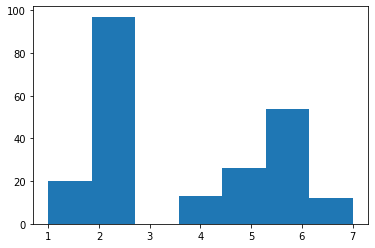

In [11]:
# show distr of TOAST Score (Stroke Cause)
plt.hist(dat.toast, bins=7)

In [12]:
#define binary toast
dat["toast_binary"] = 2
dat.loc[dat.toast != 2, "toast_binary"] = 1

(array([125.,   0.,   0.,   0.,   0.,   0.,  97.]),
 array([1.        , 1.14285714, 1.28571429, 1.42857143, 1.57142857,
        1.71428571, 1.85714286, 2.        ]),
 <BarContainer object of 7 artists>)

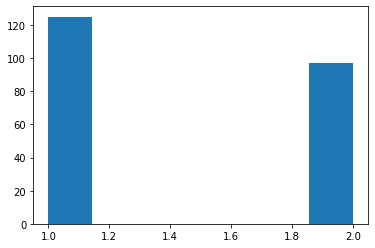

In [13]:
plt.hist(dat.toast_binary, bins=7)

#### Train, validation and test

In [14]:
# NAs?
[dat.age.isnull().sum(), 
 dat.nihss_bl.isnull().sum(),  
 dat.sys_bloodpressure_bl.isnull().sum(),
 dat.rf_diabetes.isnull().sum(), 
 dat.rf_hypertonia.isnull().sum(), 
 dat.rf_smoker.isnull().sum(),  
 dat.rf_tia_stroke.isnull().sum(), 
 dat.lyse.isnull().sum(),
 dat.time_to_groin_puncture.isnull().sum()]

[0, 0, 8, 0, 0, 20, 0, 0, 7]

In [17]:
# # simple imputation: replace all missing values with the mode of the column
# for column in dat.columns:
#     dat[column].fillna(dat[column].mode()[0], inplace=True)

In [15]:
# use the imputed data from the last project
train0 = pd.read_csv(DIR + DATA_DIR + "train_imputed_all1.csv", sep = ",")
train1 = pd.read_csv(DIR + DATA_DIR + "train_imputed_all2.csv", sep = ",")
train2 = pd.read_csv(DIR + DATA_DIR + "train_imputed_all3.csv", sep = ",")
train3 = pd.read_csv(DIR + DATA_DIR + "train_imputed_all4.csv", sep = ",")
train4 = pd.read_csv(DIR + DATA_DIR + "train_imputed_all5.csv", sep = ",")

test0 = pd.read_csv(DIR + DATA_DIR + "test_imputed_all1.csv", sep = ",")
test1 = pd.read_csv(DIR + DATA_DIR + "test_imputed_all2.csv", sep = ",")
test2 = pd.read_csv(DIR + DATA_DIR + "test_imputed_all3.csv", sep = ",")
test3 = pd.read_csv(DIR + DATA_DIR + "test_imputed_all4.csv", sep = ",")
test4 = pd.read_csv(DIR + DATA_DIR + "test_imputed_all5.csv", sep = ",")

In [16]:
train = [train0, train1, train2, train3, train4]
test = [test0, test1, test2, test3, test4]

In [17]:
# get training and test indices for CV later to impute during CV
train_idxes0 = [train0.index.values, train1.index.values, train2.index.values, train3.index.values, train4.index.values]
test_idxes = [test0.index.values, test1.index.values, test2.index.values, test3.index.values, test4.index.values]

In [18]:
my_seed = 3004

# define validation data
train_idxes = []
valid_idxes = []
for i in range(5):
    np.random.seed(my_seed)
    train_idx, valid_idx = train_test_split(train_idxes0[i], test_size = int(len(train_idxes0[i])*0.15))
    print(valid_idx)
    valid_idxes.append(np.sort(valid_idx))
    train_idxes.append(np.sort(train_idx))
    my_seed += 1
    
# define datasets: train and validation
train_old = train
train = []
valid = []
for f in range(5):
    train.append(train_old[f].loc[train_old[f].index.isin(train_idxes[f]),:])
    valid.append(train_old[f].loc[train_old[f].index.isin(valid_idxes[f]),:])

# get patient IDs
for i in range(5):
    train[i] = train[i].assign(p_id = dat.p_id[train_idxes[i]-1].values)
    valid[i] = valid[i].assign(p_id = dat.p_id[valid_idxes[i]-1].values)
    test[i] = test[i].assign(p_id = dat.p_id[test_idxes[i]-1].values)
    
# get toast score
for i in range(5):
    train[i] = train[i].assign(toast = dat.toast[train_idxes[i]-1].values)
    valid[i] = valid[i].assign(toast = dat.toast[valid_idxes[i]-1].values)
    test[i] = test[i].assign(toast = dat.toast[test_idxes[i]-1].values)

[ 49 110  98  83  18 141 134 218 221  44 139 108  65   4  57 104 151  60
  54 194   3 130 156 128 212 114]
[146  84  56  49 188  95 106 147 139  26  53 133 183 152 155 143 207  88
   5 206 102 179 120 128  65 181]
[ 34  41  96  35 188  53  57 190 120  69  40   3  45 146  59 134 220 127
 130  64  78 108 153   4  21 165]
[214 185  12  55 178  36 166  76 133  82 153  26  73 141 118 107  81 139
 115  70 123  31  83 197  69 184]
[122   4  98 219 107  97 191 156  67  93 113  91 130 169 134 153  63  77
 148  40  35 116 183 171 212  45]


In [66]:
# check if indices overlap
# np.sort(train[0].index.values)
# np.sort(valid[0].index.values)
# np.sort(test[0].index.values)

pandas.core.frame.DataFrame

In [68]:
# save imputed datasets with p_id, toast and image information
#for i in range(5):
#    train[i].to_csv(DIR + DATA_DIR + "train_imputed_all" + str(i) + "_cause.csv", sep = ",")
#for i in range(5):
#    test[i].to_csv(DIR + DATA_DIR + "test_imputed_all" + str(i) + "_cause.csv", sep = ",")

In [23]:
# #  check if image data still corresponds to tables --> works
# for i in range(5):
#     print(all(train[i].age.values.round(2) == dat.age.values[train_idxes[i]-1].round(2)))
#     print(all(valid[i].age.values.round(2) == dat.age.values[valid_idxes[i]-1].round(2)))
#     print(all(test[i].age.values.round(2) == dat.age.values[test_idxes[i]-1].round(2)))

In [19]:
Y = np.array(dat.toast_binary)
print(Y[0:5])
print(Y.shape)
Y_cat = to_categorical(Y-1)
print(Y_cat[0:5])
print(Y_cat.shape)


[2 1 1 2 1]
(222,)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
(222, 2)


# Define models

In [20]:
# Model for tabular data
def tab_model(x, output_shape):
    mod = keras.Sequential(name = "tab_mod")
    mod.add(keras.Input(shape = (x, )))
    mod.add(keras.layers.Dense(13, activation = "relu"))
    mod.add(keras.layers.Dropout(0.5))
    mod.add(keras.layers.Dense(8, activation = "relu"))
    mod.add(keras.layers.Dropout(0.5))
    mod.add(keras.layers.Dense(4, activation = "relu"))
    mod.add(keras.layers.Dense(output_shape, activation = "softmax", use_bias = False))
    return mod

mod = tab_model(4, 2)
mod.summary()

Model: "tab_mod"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 13)                65        
_________________________________________________________________
dropout (Dropout)            (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 112       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 8         
Total params: 221
Trainable params: 221
Non-trainable params: 0
_____________________________________________________________

In [21]:
# Model for tabular data
def tab_model_sigmoid(x, output_shape):
    mod = keras.Sequential(name = "tab_mod_sigmoid")
    mod.add(keras.Input(shape = (x, )))
    mod.add(keras.layers.Dense(1, activation = "sigmoid", use_bias=True))
    return mod

mod = tab_model_sigmoid(4, 1)
mod.summary()


Model: "tab_mod_sigmoid"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [22]:
def img_model_3D(input_shape, output_shape, input_name, activation = "linear"): # Input shape: (128, 128, 20, 3)
    in_ = keras.Input(shape = input_shape, name = input_name)
    x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(in_)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.Convolution3D(128, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Dropout(0.3)(x)
    out_ = layers.Dense(output_shape, activation = activation, use_bias = False)(x) # activation = linear!
    nn_im = keras.Model(inputs = in_, outputs = out_)
    return nn_im

mod = img_model_3D(X.shape[1:], 1, 'im_in', 'linear')
mod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
im_in (InputLayer)           [(None, 128, 128, 20, 3)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 128, 20, 32)  2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 20, 32)  128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 64, 64, 10, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 64, 10, 32)    27680     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 10, 32)    128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 32, 5, 32)     0     

In [23]:
def img_model_2Plus1D(input_shape, output_shape, input_name, activation = "linear"): # Input shape: (128, 128, 20, 3)
    in_ = keras.Input(shape = input_shape, name = input_name)
    x = Conv2Plus1D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(in_)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = Conv2Plus1D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = Conv2Plus1D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = Conv2Plus1D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = Conv2Plus1D(128, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Dropout(0.3)(x)
    out_ = layers.Dense(output_shape, activation = activation, use_bias = False)(x) # activation = linear!
    nn_im = keras.Model(inputs = in_, outputs = out_)
    return nn_im

mod = img_model_2Plus1D(X.shape[1:], 1, 'im_in', 'linear')
mod.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
im_in (InputLayer)           [(None, 128, 128, 20, 3)] 0         
_________________________________________________________________
conv2_plus1d (Conv2Plus1D)   (None, 128, 128, 20, 32)  4000      
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 20, 32)  128       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 64, 64, 10, 32)    0         
_________________________________________________________________
conv2_plus1d_1 (Conv2Plus1D) (None, 64, 64, 10, 32)    12352     
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 64, 10, 32)    128       
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 32, 32, 5, 32)     0   

In [25]:
X.shape[0:]

(222, 128, 128, 20, 3)

# Tabular Data

## Training

In [24]:
folder_name = "Cause_Tab/"

# # create folders: run only once
#os.mkdir(OUTPUT_DIR + folder_name)
#for i in range(5):
#    os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i))
#    for j in range(5):
#        os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i) + "/run" + str(j))

In [25]:
# Hyperparameters
batch_size = 128 # all data
epochs = 10000
from functions.keras_training_progress import PlotLearning

In [77]:
f = 0
train_idx = train_idxes[f]
test_idx = test_idxes[f]
categorial = True

# Load data for fold 0

# define datasets
X_tab_train = np.array([train[f].age, train[f].sex, train[f].antikoagulation_pre_stroke, 
                        train[f].atrial_fibrillation]).T
X_tab_valid = np.array([valid[f].age, valid[f].sex, valid[f].antikoagulation_pre_stroke, 
                        valid[f].atrial_fibrillation]).T
X_tab_test = np.array([test[f].age, test[f].sex, test[f].antikoagulation_pre_stroke, 
                       test[f].atrial_fibrillation]).T

# normalize
sd = np.empty((4,))
for i in range(X_tab_train.shape[1]):
    train_mean = np.mean(X_tab_train[:,i])
    train_std = np.std(X_tab_train[:,i])
    X_tab_train[:,i] = (X_tab_train[:,i] - train_mean) / train_std
    X_tab_valid[:,i] = (X_tab_valid[:,i] - train_mean) / train_std
    X_tab_test[:,i] = (X_tab_test[:,i] - train_mean) / train_std
    sd[i] = train_std

if categorial:
    Y_train = Y_cat[train_idx-1]
    Y_valid = Y_cat[valid_idx-1]
    Y_test = Y_cat[test_idx-1]
else:
    Y_train = Y[train_idx-1]
    Y_valid = Y[valid_idx-1]
    Y_test = Y[test_idx-1]
    
dat_train = train[f]
dat_valid = valid[f]
dat_test = test[f]

dat_train.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(f) + "/" + "dat_train.csv", index = False)
dat_valid.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(f) + "/" + "dat_valid.csv", index = False)
dat_test.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(f) + "/" + "dat_test.csv", index = False)


# Define datasets

train_data = tf.data.Dataset.from_tensor_slices((X_tab_train))
train_labels = tf.data.Dataset.from_tensor_slices((Y_train))

valid_data = tf.data.Dataset.from_tensor_slices((X_tab_valid))
valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))

test_data = tf.data.Dataset.from_tensor_slices((X_tab_test))
test_labels = tf.data.Dataset.from_tensor_slices((Y_test))

train_loader = tf.data.Dataset.zip((train_data, train_labels))
validation_loader = tf.data.Dataset.zip((valid_data, valid_labels))
test_loader = tf.data.Dataset.zip((test_data, test_labels))

train_dataset = (train_loader.shuffle(len(X_tab_train)).batch(batch_size, drop_remainder=True))
validation_dataset = (validation_loader.batch(batch_size, drop_remainder=True))
test_dataset = (test_loader.batch(len(X_tab_test)))



In [78]:
# Training complex model

# define model for tabular data
model = tab_model(X_tab_train.shape[1], 2)

# compile and train
model.compile(optimizer = keras.optimizers.Adam(),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

callbacks_list = [PlotLearning()]

history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = epochs,
                    shuffle = True)

checkpoint_filepath = OUTPUT_DIR + folder_name + "fold" + str(f) + "/" + "run" + str(1) + "/"
pd.DataFrame(history.history).to_csv(checkpoint_filepath + "history.csv", index = False)
model.save_weights(checkpoint_filepath + "model_weights.hdf5")

Epoch 1/10000
1/1 [==============================] - 0s 261ms/step - loss: 0.6977 - accuracy: 0.5078
Epoch 2/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.7297 - accuracy: 0.4297
Epoch 3/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.6961 - accuracy: 0.5625
Epoch 4/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.7046 - accuracy: 0.4531
Epoch 5/10000
1/1 [==============================] - 0s 108ms/step - loss: 0.7107 - accuracy: 0.5000
Epoch 6/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.7203 - accuracy: 0.4453
Epoch 7/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.7054 - accuracy: 0.5234
Epoch 8/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.7119 - accuracy: 0.5312
Epoch 9/10000
1/1 [==============================] - 0s 27ms/step - loss: 0.7131 - accuracy: 0.4922
Epoch 10/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.6916 - accuracy: 0.53

1/1 [==============================] - 0s 28ms/step - loss: 0.4519 - accuracy: 0.8281
Epoch 163/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.4734 - accuracy: 0.7734
Epoch 164/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.4571 - accuracy: 0.7969
Epoch 165/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.4359 - accuracy: 0.8438
Epoch 166/10000
1/1 [==============================] - 0s 27ms/step - loss: 0.4472 - accuracy: 0.7656
Epoch 167/10000
1/1 [==============================] - 0s 45ms/step - loss: 0.4342 - accuracy: 0.8438
Epoch 168/10000
1/1 [==============================] - 0s 24ms/step - loss: 0.4609 - accuracy: 0.8125
Epoch 169/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.4924 - accuracy: 0.7891
Epoch 170/10000
1/1 [==============================] - 0s 39ms/step - loss: 0.4406 - accuracy: 0.7969
Epoch 171/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.4327 - accuracy: 0.7

1/1 [==============================] - 0s 18ms/step - loss: 0.3004 - accuracy: 0.8828
Epoch 323/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3896 - accuracy: 0.8594
Epoch 324/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.2867 - accuracy: 0.8906
Epoch 325/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.3365 - accuracy: 0.8594
Epoch 326/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3450 - accuracy: 0.8594
Epoch 327/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.3418 - accuracy: 0.8672
Epoch 328/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3830 - accuracy: 0.8594
Epoch 329/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.3741 - accuracy: 0.8516
Epoch 330/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3150 - accuracy: 0.8672
Epoch 331/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2938 - accuracy: 0.8

1/1 [==============================] - 0s 27ms/step - loss: 0.3212 - accuracy: 0.8828
Epoch 483/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.3095 - accuracy: 0.8750
Epoch 484/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.3620 - accuracy: 0.8594
Epoch 485/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2613 - accuracy: 0.8906
Epoch 486/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.3055 - accuracy: 0.9219
Epoch 487/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3207 - accuracy: 0.8516
Epoch 488/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.3906 - accuracy: 0.8438
Epoch 489/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.3250 - accuracy: 0.8984
Epoch 490/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2863 - accuracy: 0.8984
Epoch 491/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3341 - accuracy: 0.8

1/1 [==============================] - 0s 41ms/step - loss: 0.2105 - accuracy: 0.9219
Epoch 643/10000
1/1 [==============================] - 0s 118ms/step - loss: 0.2451 - accuracy: 0.9219
Epoch 644/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2779 - accuracy: 0.9297
Epoch 645/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2997 - accuracy: 0.8750
Epoch 646/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.3030 - accuracy: 0.9141
Epoch 647/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3462 - accuracy: 0.8828
Epoch 648/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2784 - accuracy: 0.8828
Epoch 649/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.3178 - accuracy: 0.9219
Epoch 650/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.2800 - accuracy: 0.9062
Epoch 651/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2827 - accuracy: 0.

1/1 [==============================] - 0s 18ms/step - loss: 0.3174 - accuracy: 0.9062
Epoch 803/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2796 - accuracy: 0.9297
Epoch 804/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.2920 - accuracy: 0.9219
Epoch 805/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2951 - accuracy: 0.9297
Epoch 806/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2933 - accuracy: 0.8984
Epoch 807/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2744 - accuracy: 0.9062
Epoch 808/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3035 - accuracy: 0.9062
Epoch 809/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2880 - accuracy: 0.9062
Epoch 810/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2293 - accuracy: 0.9141
Epoch 811/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2821 - accuracy: 0.9

1/1 [==============================] - 0s 21ms/step - loss: 0.2790 - accuracy: 0.8906
Epoch 963/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3604 - accuracy: 0.8906
Epoch 964/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2648 - accuracy: 0.9141
Epoch 965/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2311 - accuracy: 0.9219
Epoch 966/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2661 - accuracy: 0.9141
Epoch 967/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2808 - accuracy: 0.8984
Epoch 968/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3089 - accuracy: 0.8828
Epoch 969/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2800 - accuracy: 0.9141
Epoch 970/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2908 - accuracy: 0.9141
Epoch 971/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2862 - accuracy: 0.8

1/1 [==============================] - 0s 34ms/step - loss: 0.3224 - accuracy: 0.9062
Epoch 1043/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.3009 - accuracy: 0.9219
Epoch 1044/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2489 - accuracy: 0.8906
Epoch 1045/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2590 - accuracy: 0.9141
Epoch 1046/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2756 - accuracy: 0.9297
Epoch 1047/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.2603 - accuracy: 0.9141
Epoch 1048/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.2819 - accuracy: 0.8828
Epoch 1049/10000
1/1 [==============================] - 0s 119ms/step - loss: 0.2934 - accuracy: 0.9141
Epoch 1050/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2542 - accuracy: 0.9141
Epoch 1051/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3136 - acc

1/1 [==============================] - 0s 25ms/step - loss: 0.2420 - accuracy: 0.9297
Epoch 1201/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2931 - accuracy: 0.9062
Epoch 1202/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2848 - accuracy: 0.9141
Epoch 1203/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2505 - accuracy: 0.9297
Epoch 1204/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3366 - accuracy: 0.9141
Epoch 1205/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2950 - accuracy: 0.9297
Epoch 1206/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3211 - accuracy: 0.8750
Epoch 1207/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.2894 - accuracy: 0.9141
Epoch 1208/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2627 - accuracy: 0.9141
Epoch 1209/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.3084 - accu

1/1 [==============================] - 0s 18ms/step - loss: 0.2802 - accuracy: 0.9062
Epoch 1359/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2590 - accuracy: 0.9141
Epoch 1360/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2618 - accuracy: 0.9219
Epoch 1361/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2437 - accuracy: 0.9141
Epoch 1362/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2434 - accuracy: 0.9375
Epoch 1363/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2911 - accuracy: 0.8906
Epoch 1364/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2043 - accuracy: 0.9453
Epoch 1365/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2497 - accuracy: 0.9219
Epoch 1366/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2461 - accuracy: 0.9141
Epoch 1367/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2149 - accu

1/1 [==============================] - 0s 17ms/step - loss: 0.1915 - accuracy: 0.9297
Epoch 1517/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2192 - accuracy: 0.9297
Epoch 1518/10000
1/1 [==============================] - 0s 27ms/step - loss: 0.2732 - accuracy: 0.9219
Epoch 1519/10000
1/1 [==============================] - 0s 42ms/step - loss: 0.2522 - accuracy: 0.9219
Epoch 1520/10000
1/1 [==============================] - 0s 24ms/step - loss: 0.2842 - accuracy: 0.9141
Epoch 1521/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2340 - accuracy: 0.9141
Epoch 1522/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2441 - accuracy: 0.9141
Epoch 1523/10000
1/1 [==============================] - 0s 41ms/step - loss: 0.3218 - accuracy: 0.8984
Epoch 1524/10000
1/1 [==============================] - 0s 24ms/step - loss: 0.2769 - accuracy: 0.9062
Epoch 1525/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2595 - accu

1/1 [==============================] - 0s 35ms/step - loss: 0.3054 - accuracy: 0.9141
Epoch 1675/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.2133 - accuracy: 0.9219
Epoch 1676/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2595 - accuracy: 0.9375
Epoch 1677/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2299 - accuracy: 0.9219
Epoch 1678/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2340 - accuracy: 0.9297
Epoch 1679/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.2093 - accuracy: 0.9062
Epoch 1680/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2772 - accuracy: 0.9297
Epoch 1681/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2769 - accuracy: 0.9219
Epoch 1682/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2466 - accuracy: 0.9297
Epoch 1683/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2340 - accu

1/1 [==============================] - 0s 19ms/step - loss: 0.2349 - accuracy: 0.9219
Epoch 1833/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2821 - accuracy: 0.8906
Epoch 1834/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2729 - accuracy: 0.9141
Epoch 1835/10000
1/1 [==============================] - 0s 40ms/step - loss: 0.2398 - accuracy: 0.9297
Epoch 1836/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.2286 - accuracy: 0.9375
Epoch 1837/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2223 - accuracy: 0.9219
Epoch 1838/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3005 - accuracy: 0.9141
Epoch 1839/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2874 - accuracy: 0.8984
Epoch 1840/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3163 - accuracy: 0.8906
Epoch 1841/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2919 - accu

1/1 [==============================] - 0s 35ms/step - loss: 0.2998 - accuracy: 0.9141
Epoch 1991/10000
1/1 [==============================] - 0s 24ms/step - loss: 0.2792 - accuracy: 0.9219
Epoch 1992/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.2724 - accuracy: 0.8984
Epoch 1993/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2838 - accuracy: 0.9219
Epoch 1994/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2313 - accuracy: 0.9297
Epoch 1995/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2739 - accuracy: 0.9141
Epoch 1996/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2524 - accuracy: 0.9219
Epoch 1997/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2204 - accuracy: 0.9297
Epoch 1998/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2544 - accuracy: 0.9219
Epoch 1999/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.2130 - accu

1/1 [==============================] - 0s 19ms/step - loss: 0.2434 - accuracy: 0.9219
Epoch 2149/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2271 - accuracy: 0.9141
Epoch 2150/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2990 - accuracy: 0.8984
Epoch 2151/10000
1/1 [==============================] - 0s 105ms/step - loss: 0.2632 - accuracy: 0.9141
Epoch 2152/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2549 - accuracy: 0.9297
Epoch 2153/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.2839 - accuracy: 0.9297
Epoch 2154/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2171 - accuracy: 0.9375
Epoch 2155/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2638 - accuracy: 0.8984
Epoch 2156/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.2863 - accuracy: 0.9141
Epoch 2157/10000
1/1 [==============================] - 0s 28ms/step - loss: 0.2468 - acc

1/1 [==============================] - 0s 35ms/step - loss: 0.2355 - accuracy: 0.9375
Epoch 2307/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2582 - accuracy: 0.9297
Epoch 2308/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2705 - accuracy: 0.9219
Epoch 2309/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2021 - accuracy: 0.9375
Epoch 2310/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2409 - accuracy: 0.9219
Epoch 2311/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2468 - accuracy: 0.9297
Epoch 2312/10000
1/1 [==============================] - 0s 25ms/step - loss: 0.2607 - accuracy: 0.9141
Epoch 2313/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.2185 - accuracy: 0.9141
Epoch 2314/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2458 - accuracy: 0.9141
Epoch 2315/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2737 - accu

1/1 [==============================] - 0s 21ms/step - loss: 0.2463 - accuracy: 0.9062
Epoch 2465/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2672 - accuracy: 0.9219
Epoch 2466/10000
1/1 [==============================] - 0s 41ms/step - loss: 0.2580 - accuracy: 0.9141
Epoch 2467/10000
1/1 [==============================] - 0s 41ms/step - loss: 0.2804 - accuracy: 0.9141
Epoch 2468/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.3036 - accuracy: 0.8906
Epoch 2469/10000
1/1 [==============================] - 0s 41ms/step - loss: 0.3345 - accuracy: 0.8828
Epoch 2470/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.1918 - accuracy: 0.9609
Epoch 2471/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2219 - accuracy: 0.9141
Epoch 2472/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2627 - accuracy: 0.9375
Epoch 2473/10000
1/1 [==============================] - 0s 26ms/step - loss: 0.2575 - accu

1/1 [==============================] - 0s 31ms/step - loss: 0.2359 - accuracy: 0.9297
Epoch 2623/10000
1/1 [==============================] - 0s 43ms/step - loss: 0.2772 - accuracy: 0.9141
Epoch 2624/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.2346 - accuracy: 0.9062
Epoch 2625/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2519 - accuracy: 0.9219
Epoch 2626/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3179 - accuracy: 0.9219
Epoch 2627/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2837 - accuracy: 0.9062
Epoch 2628/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2008 - accuracy: 0.9375
Epoch 2629/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2633 - accuracy: 0.9219
Epoch 2630/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.2690 - accuracy: 0.9219
Epoch 2631/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.1894 - accu

1/1 [==============================] - 0s 17ms/step - loss: 0.2319 - accuracy: 0.9453
Epoch 2781/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2635 - accuracy: 0.9062
Epoch 2782/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2865 - accuracy: 0.9219
Epoch 2783/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.2434 - accuracy: 0.9297
Epoch 2784/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2435 - accuracy: 0.9297
Epoch 2785/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2886 - accuracy: 0.9062
Epoch 2786/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.2734 - accuracy: 0.9375
Epoch 2787/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2504 - accuracy: 0.9375
Epoch 2788/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2781 - accuracy: 0.8984
Epoch 2789/10000
1/1 [==============================] - 0s 120ms/step - loss: 0.2821 - acc

1/1 [==============================] - 0s 29ms/step - loss: 0.2818 - accuracy: 0.9141
Epoch 2939/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2568 - accuracy: 0.9375
Epoch 2940/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.2216 - accuracy: 0.9375
Epoch 2941/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.1886 - accuracy: 0.9531
Epoch 2942/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2621 - accuracy: 0.9297
Epoch 2943/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3122 - accuracy: 0.8906
Epoch 2944/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2604 - accuracy: 0.9453
Epoch 2945/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2701 - accuracy: 0.9062
Epoch 2946/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2694 - accuracy: 0.9141
Epoch 2947/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2224 - accu

1/1 [==============================] - 0s 17ms/step - loss: 0.2470 - accuracy: 0.9141
Epoch 3097/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2687 - accuracy: 0.9297
Epoch 3098/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.2508 - accuracy: 0.9062
Epoch 3099/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.1765 - accuracy: 0.9453
Epoch 3100/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2715 - accuracy: 0.9141
Epoch 3101/10000
1/1 [==============================] - 0s 27ms/step - loss: 0.2339 - accuracy: 0.9141
Epoch 3102/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2813 - accuracy: 0.9219
Epoch 3103/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.2723 - accuracy: 0.8984
Epoch 3104/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2510 - accuracy: 0.9219
Epoch 3105/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2281 - accu

1/1 [==============================] - 0s 19ms/step - loss: 0.2346 - accuracy: 0.9219
Epoch 3255/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2681 - accuracy: 0.8906
Epoch 3256/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.2353 - accuracy: 0.9062
Epoch 3257/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2377 - accuracy: 0.9062
Epoch 3258/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.2314 - accuracy: 0.9375
Epoch 3259/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.1869 - accuracy: 0.9453
Epoch 3260/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2677 - accuracy: 0.8984
Epoch 3261/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2605 - accuracy: 0.9141
Epoch 3262/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2267 - accuracy: 0.9141
Epoch 3263/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.3006 - accu

1/1 [==============================] - 0s 35ms/step - loss: 0.2765 - accuracy: 0.9141
Epoch 3413/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.2144 - accuracy: 0.9297
Epoch 3414/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.2273 - accuracy: 0.9219
Epoch 3415/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.2094 - accuracy: 0.9375
Epoch 3416/10000
1/1 [==============================] - 0s 28ms/step - loss: 0.2557 - accuracy: 0.9219
Epoch 3417/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2028 - accuracy: 0.9453
Epoch 3418/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.1918 - accuracy: 0.9375
Epoch 3419/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2925 - accuracy: 0.9219
Epoch 3420/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2737 - accuracy: 0.9141
Epoch 3421/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.2943 - accu

1/1 [==============================] - 0s 24ms/step - loss: 0.2448 - accuracy: 0.9141
Epoch 3571/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.1999 - accuracy: 0.9297
Epoch 3572/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2237 - accuracy: 0.9297
Epoch 3573/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2367 - accuracy: 0.9141
Epoch 3574/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2244 - accuracy: 0.9297
Epoch 3575/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.2402 - accuracy: 0.9297
Epoch 3576/10000
1/1 [==============================] - 0s 27ms/step - loss: 0.2863 - accuracy: 0.9141
Epoch 3577/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2437 - accuracy: 0.9219
Epoch 3578/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2229 - accuracy: 0.9375
Epoch 3579/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2748 - accu

1/1 [==============================] - 0s 32ms/step - loss: 0.2353 - accuracy: 0.9062
Epoch 3729/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2042 - accuracy: 0.9375
Epoch 3730/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2748 - accuracy: 0.8984
Epoch 3731/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.2165 - accuracy: 0.9453
Epoch 3732/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2181 - accuracy: 0.9375
Epoch 3733/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2203 - accuracy: 0.9297
Epoch 3734/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2583 - accuracy: 0.9062
Epoch 3735/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2796 - accuracy: 0.9062
Epoch 3736/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2111 - accuracy: 0.9141
Epoch 3737/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2393 - accu

1/1 [==============================] - 0s 18ms/step - loss: 0.2664 - accuracy: 0.9141
Epoch 3887/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.2120 - accuracy: 0.9453
Epoch 3888/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.2285 - accuracy: 0.9297
Epoch 3889/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.2694 - accuracy: 0.8984
Epoch 3890/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2811 - accuracy: 0.9141
Epoch 3891/10000
1/1 [==============================] - 0s 102ms/step - loss: 0.2471 - accuracy: 0.9062
Epoch 3892/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2000 - accuracy: 0.9375
Epoch 3893/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.2226 - accuracy: 0.9219
Epoch 3894/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2646 - accuracy: 0.9219
Epoch 3895/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2796 - acc

1/1 [==============================] - 0s 18ms/step - loss: 0.2634 - accuracy: 0.9141
Epoch 4045/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.2332 - accuracy: 0.9219
Epoch 4046/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2854 - accuracy: 0.9062
Epoch 4047/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2551 - accuracy: 0.9141
Epoch 4048/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.1861 - accuracy: 0.9375
Epoch 4049/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2582 - accuracy: 0.9141
Epoch 4050/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2539 - accuracy: 0.9141
Epoch 4051/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2344 - accuracy: 0.9297
Epoch 4052/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2369 - accuracy: 0.9141
Epoch 4053/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2631 - accu

1/1 [==============================] - 0s 36ms/step - loss: 0.2664 - accuracy: 0.9062
Epoch 4203/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2284 - accuracy: 0.9297
Epoch 4204/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.2561 - accuracy: 0.9297
Epoch 4205/10000
1/1 [==============================] - 0s 41ms/step - loss: 0.3007 - accuracy: 0.9141
Epoch 4206/10000
1/1 [==============================] - 0s 40ms/step - loss: 0.2434 - accuracy: 0.9219
Epoch 4207/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.2515 - accuracy: 0.9297
Epoch 4208/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2647 - accuracy: 0.9062
Epoch 4209/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2274 - accuracy: 0.9375
Epoch 4210/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2310 - accuracy: 0.9297
Epoch 4211/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2468 - accu

1/1 [==============================] - 0s 30ms/step - loss: 0.1651 - accuracy: 0.9453
Epoch 4361/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.2231 - accuracy: 0.9297
Epoch 4362/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2372 - accuracy: 0.9375
Epoch 4363/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2464 - accuracy: 0.9297
Epoch 4364/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.2590 - accuracy: 0.9062
Epoch 4365/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.2753 - accuracy: 0.8984
Epoch 4366/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2717 - accuracy: 0.8984
Epoch 4367/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2339 - accuracy: 0.9297
Epoch 4368/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2886 - accuracy: 0.8828
Epoch 4369/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2463 - accu

1/1 [==============================] - 0s 36ms/step - loss: 0.2380 - accuracy: 0.9141
Epoch 4519/10000
1/1 [==============================] - 0s 24ms/step - loss: 0.3031 - accuracy: 0.8984
Epoch 4520/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2058 - accuracy: 0.9141
Epoch 4521/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2634 - accuracy: 0.9141
Epoch 4522/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2873 - accuracy: 0.9062
Epoch 4523/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2250 - accuracy: 0.9141
Epoch 4524/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.2307 - accuracy: 0.9297
Epoch 4525/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2470 - accuracy: 0.9141
Epoch 4526/10000
1/1 [==============================] - 0s 24ms/step - loss: 0.1852 - accuracy: 0.9453
Epoch 4527/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2622 - accu

1/1 [==============================] - 0s 19ms/step - loss: 0.2475 - accuracy: 0.9141
Epoch 4677/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.1874 - accuracy: 0.9219
Epoch 4678/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2329 - accuracy: 0.9297
Epoch 4679/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2271 - accuracy: 0.9219
Epoch 4680/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2450 - accuracy: 0.9375
Epoch 4681/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2516 - accuracy: 0.9141
Epoch 4682/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2299 - accuracy: 0.9375
Epoch 4683/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2324 - accuracy: 0.9141
Epoch 4684/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2861 - accuracy: 0.9062
Epoch 4685/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2369 - accu

1/1 [==============================] - 0s 18ms/step - loss: 0.2483 - accuracy: 0.9141
Epoch 4835/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2489 - accuracy: 0.9297
Epoch 4836/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2632 - accuracy: 0.9219
Epoch 4837/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2805 - accuracy: 0.9141
Epoch 4838/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2566 - accuracy: 0.9297
Epoch 4839/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2541 - accuracy: 0.8984
Epoch 4840/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2686 - accuracy: 0.9062
Epoch 4841/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2470 - accuracy: 0.9141
Epoch 4842/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.1934 - accuracy: 0.9375
Epoch 4843/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2657 - accu

1/1 [==============================] - 0s 19ms/step - loss: 0.2658 - accuracy: 0.9062
Epoch 4993/10000
1/1 [==============================] - 0s 111ms/step - loss: 0.2835 - accuracy: 0.9062
Epoch 4994/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2428 - accuracy: 0.9297
Epoch 4995/10000
1/1 [==============================] - 0s 24ms/step - loss: 0.2702 - accuracy: 0.9062
Epoch 4996/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2124 - accuracy: 0.9375
Epoch 4997/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.2660 - accuracy: 0.9062
Epoch 4998/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2231 - accuracy: 0.9219
Epoch 4999/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2244 - accuracy: 0.9219
Epoch 5000/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2205 - accuracy: 0.9297
Epoch 5001/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2047 - acc

1/1 [==============================] - 0s 20ms/step - loss: 0.2131 - accuracy: 0.9297
Epoch 5151/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2453 - accuracy: 0.9219
Epoch 5152/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2183 - accuracy: 0.9375
Epoch 5153/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.2026 - accuracy: 0.9375
Epoch 5154/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2778 - accuracy: 0.8984
Epoch 5155/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2631 - accuracy: 0.9062
Epoch 5156/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.2393 - accuracy: 0.9297
Epoch 5157/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2093 - accuracy: 0.9297
Epoch 5158/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2648 - accuracy: 0.9219
Epoch 5159/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2608 - accu

1/1 [==============================] - 0s 32ms/step - loss: 0.2218 - accuracy: 0.9219
Epoch 5309/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2527 - accuracy: 0.9297
Epoch 5310/10000
1/1 [==============================] - 0s 43ms/step - loss: 0.2202 - accuracy: 0.9219
Epoch 5311/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2131 - accuracy: 0.9453
Epoch 5312/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2179 - accuracy: 0.9297
Epoch 5313/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2545 - accuracy: 0.9141
Epoch 5314/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2116 - accuracy: 0.9219
Epoch 5315/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2517 - accuracy: 0.9219
Epoch 5316/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2533 - accuracy: 0.9141
Epoch 5317/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2520 - accu

1/1 [==============================] - 0s 18ms/step - loss: 0.2585 - accuracy: 0.9219
Epoch 5467/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2063 - accuracy: 0.9531
Epoch 5468/10000
1/1 [==============================] - 0s 42ms/step - loss: 0.2473 - accuracy: 0.9219
Epoch 5469/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2414 - accuracy: 0.9062
Epoch 5470/10000
1/1 [==============================] - 0s 41ms/step - loss: 0.1800 - accuracy: 0.9453
Epoch 5471/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.1853 - accuracy: 0.9531
Epoch 5472/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.1936 - accuracy: 0.9453
Epoch 5473/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2465 - accuracy: 0.9141
Epoch 5474/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.2317 - accuracy: 0.9141
Epoch 5475/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2677 - accu

1/1 [==============================] - 0s 35ms/step - loss: 0.2694 - accuracy: 0.8906
Epoch 5625/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2711 - accuracy: 0.9141
Epoch 5626/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.1840 - accuracy: 0.9453
Epoch 5627/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2570 - accuracy: 0.9219
Epoch 5628/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2096 - accuracy: 0.9375
Epoch 5629/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2857 - accuracy: 0.9062
Epoch 5630/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.2195 - accuracy: 0.9219
Epoch 5631/10000
1/1 [==============================] - 0s 106ms/step - loss: 0.2420 - accuracy: 0.9375
Epoch 5632/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2166 - accuracy: 0.9297
Epoch 5633/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2613 - acc

1/1 [==============================] - 0s 17ms/step - loss: 0.2593 - accuracy: 0.9219
Epoch 5783/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2423 - accuracy: 0.9297
Epoch 5784/10000
1/1 [==============================] - 0s 39ms/step - loss: 0.2544 - accuracy: 0.9219
Epoch 5785/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2610 - accuracy: 0.9062
Epoch 5786/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2654 - accuracy: 0.9141
Epoch 5787/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2140 - accuracy: 0.9375
Epoch 5788/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2186 - accuracy: 0.9297
Epoch 5789/10000
1/1 [==============================] - 0s 42ms/step - loss: 0.2403 - accuracy: 0.9297
Epoch 5790/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2359 - accuracy: 0.9219
Epoch 5791/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.2159 - accu

1/1 [==============================] - 0s 35ms/step - loss: 0.2164 - accuracy: 0.9375
Epoch 5941/10000
1/1 [==============================] - 0s 43ms/step - loss: 0.2309 - accuracy: 0.9219
Epoch 5942/10000
1/1 [==============================] - 0s 39ms/step - loss: 0.2253 - accuracy: 0.9453
Epoch 5943/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.2226 - accuracy: 0.9297
Epoch 5944/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.1921 - accuracy: 0.9531
Epoch 5945/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2289 - accuracy: 0.9219
Epoch 5946/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.2191 - accuracy: 0.9219
Epoch 5947/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2557 - accuracy: 0.9297
Epoch 5948/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2302 - accuracy: 0.9219
Epoch 5949/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2477 - accu

1/1 [==============================] - 0s 17ms/step - loss: 0.2530 - accuracy: 0.9062
Epoch 6099/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2710 - accuracy: 0.9062
Epoch 6100/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2724 - accuracy: 0.9141
Epoch 6101/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2668 - accuracy: 0.9141
Epoch 6102/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2192 - accuracy: 0.9297
Epoch 6103/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2586 - accuracy: 0.8984
Epoch 6104/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.2614 - accuracy: 0.9219
Epoch 6105/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2611 - accuracy: 0.9062
Epoch 6106/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2127 - accuracy: 0.9297
Epoch 6107/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.1841 - accu

1/1 [==============================] - 0s 19ms/step - loss: 0.2380 - accuracy: 0.9062
Epoch 6257/10000
1/1 [==============================] - 0s 41ms/step - loss: 0.2267 - accuracy: 0.9141
Epoch 6258/10000
1/1 [==============================] - 0s 42ms/step - loss: 0.2539 - accuracy: 0.9141
Epoch 6259/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2073 - accuracy: 0.9375
Epoch 6260/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2208 - accuracy: 0.9219
Epoch 6261/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.2766 - accuracy: 0.8906
Epoch 6262/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2593 - accuracy: 0.9062
Epoch 6263/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2599 - accuracy: 0.9141
Epoch 6264/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2350 - accuracy: 0.9219
Epoch 6265/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2649 - accu

1/1 [==============================] - 0s 28ms/step - loss: 0.2068 - accuracy: 0.9219
Epoch 6415/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2595 - accuracy: 0.9062
Epoch 6416/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2142 - accuracy: 0.9297
Epoch 6417/10000
1/1 [==============================] - 0s 27ms/step - loss: 0.2717 - accuracy: 0.9141
Epoch 6418/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.2269 - accuracy: 0.9297
Epoch 6419/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.2122 - accuracy: 0.9375
Epoch 6420/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2712 - accuracy: 0.9062
Epoch 6421/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.1991 - accuracy: 0.9531
Epoch 6422/10000
1/1 [==============================] - 0s 28ms/step - loss: 0.2030 - accuracy: 0.9453
Epoch 6423/10000
1/1 [==============================] - 0s 27ms/step - loss: 0.1989 - accu

1/1 [==============================] - 0s 18ms/step - loss: 0.2229 - accuracy: 0.9219
Epoch 6573/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.1845 - accuracy: 0.9375
Epoch 6574/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2434 - accuracy: 0.9219
Epoch 6575/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2871 - accuracy: 0.9062
Epoch 6576/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2347 - accuracy: 0.9297
Epoch 6577/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.2292 - accuracy: 0.9219
Epoch 6578/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.1975 - accuracy: 0.9453
Epoch 6579/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.2633 - accuracy: 0.8984
Epoch 6580/10000
1/1 [==============================] - 0s 44ms/step - loss: 0.2749 - accuracy: 0.8984
Epoch 6581/10000
1/1 [==============================] - 0s 47ms/step - loss: 0.2182 - accu

1/1 [==============================] - 0s 33ms/step - loss: 0.2607 - accuracy: 0.9219
Epoch 6731/10000
1/1 [==============================] - 0s 39ms/step - loss: 0.1838 - accuracy: 0.9531
Epoch 6732/10000
1/1 [==============================] - 0s 24ms/step - loss: 0.2561 - accuracy: 0.9219
Epoch 6733/10000
1/1 [==============================] - 0s 114ms/step - loss: 0.1910 - accuracy: 0.9531
Epoch 6734/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.1962 - accuracy: 0.9453
Epoch 6735/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2288 - accuracy: 0.9219
Epoch 6736/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2645 - accuracy: 0.9062
Epoch 6737/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2375 - accuracy: 0.9297
Epoch 6738/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.1796 - accuracy: 0.9453
Epoch 6739/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2498 - acc

1/1 [==============================] - 0s 34ms/step - loss: 0.2383 - accuracy: 0.9062
Epoch 6889/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2270 - accuracy: 0.9219
Epoch 6890/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2535 - accuracy: 0.9062
Epoch 6891/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2911 - accuracy: 0.8984
Epoch 6892/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.1963 - accuracy: 0.9453
Epoch 6893/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2489 - accuracy: 0.9141
Epoch 6894/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2661 - accuracy: 0.9219
Epoch 6895/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.2432 - accuracy: 0.9375
Epoch 6896/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2244 - accuracy: 0.9219
Epoch 6897/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.2349 - accu

1/1 [==============================] - 0s 30ms/step - loss: 0.2029 - accuracy: 0.9453
Epoch 7047/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.1698 - accuracy: 0.9453
Epoch 7048/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2135 - accuracy: 0.9297
Epoch 7049/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.3003 - accuracy: 0.8906
Epoch 7050/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2091 - accuracy: 0.9375
Epoch 7051/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2521 - accuracy: 0.9219
Epoch 7052/10000
1/1 [==============================] - 0s 40ms/step - loss: 0.2627 - accuracy: 0.9141
Epoch 7053/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.2867 - accuracy: 0.8906
Epoch 7054/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2219 - accuracy: 0.9297
Epoch 7055/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2264 - accu

1/1 [==============================] - 0s 17ms/step - loss: 0.2621 - accuracy: 0.9141
Epoch 7205/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2898 - accuracy: 0.8906
Epoch 7206/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2432 - accuracy: 0.9141
Epoch 7207/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.2244 - accuracy: 0.9375
Epoch 7208/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2443 - accuracy: 0.9141
Epoch 7209/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2502 - accuracy: 0.9141
Epoch 7210/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2238 - accuracy: 0.9219
Epoch 7211/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2374 - accuracy: 0.9297
Epoch 7212/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.2057 - accuracy: 0.9297
Epoch 7213/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2027 - accu

1/1 [==============================] - 0s 21ms/step - loss: 0.2829 - accuracy: 0.9062
Epoch 7363/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2080 - accuracy: 0.9375
Epoch 7364/10000
1/1 [==============================] - 0s 42ms/step - loss: 0.2669 - accuracy: 0.9062
Epoch 7365/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2335 - accuracy: 0.9375
Epoch 7366/10000
1/1 [==============================] - 0s 42ms/step - loss: 0.2312 - accuracy: 0.9297
Epoch 7367/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2165 - accuracy: 0.9375
Epoch 7368/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2921 - accuracy: 0.8984
Epoch 7369/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2205 - accuracy: 0.9219
Epoch 7370/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2125 - accuracy: 0.9375
Epoch 7371/10000
1/1 [==============================] - 0s 103ms/step - loss: 0.2061 - acc

1/1 [==============================] - 0s 17ms/step - loss: 0.1969 - accuracy: 0.9375
Epoch 7521/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2283 - accuracy: 0.9219
Epoch 7522/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2372 - accuracy: 0.9297
Epoch 7523/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2692 - accuracy: 0.9219
Epoch 7524/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2520 - accuracy: 0.9062
Epoch 7525/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2340 - accuracy: 0.9219
Epoch 7526/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2441 - accuracy: 0.9219
Epoch 7527/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2613 - accuracy: 0.9062
Epoch 7528/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2071 - accuracy: 0.9375
Epoch 7529/10000
1/1 [==============================] - 0s 40ms/step - loss: 0.2952 - accu

1/1 [==============================] - 0s 25ms/step - loss: 0.2407 - accuracy: 0.9219
Epoch 7679/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2638 - accuracy: 0.9219
Epoch 7680/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.1581 - accuracy: 0.9609
Epoch 7681/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2178 - accuracy: 0.9297
Epoch 7682/10000
1/1 [==============================] - 0s 27ms/step - loss: 0.2374 - accuracy: 0.9141
Epoch 7683/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2823 - accuracy: 0.8984
Epoch 7684/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.2694 - accuracy: 0.9062
Epoch 7685/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2103 - accuracy: 0.9297
Epoch 7686/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2995 - accuracy: 0.8750
Epoch 7687/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2625 - accu

1/1 [==============================] - 0s 34ms/step - loss: 0.2502 - accuracy: 0.8984
Epoch 7837/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2593 - accuracy: 0.8984
Epoch 7838/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2275 - accuracy: 0.9375
Epoch 7839/10000
1/1 [==============================] - 0s 40ms/step - loss: 0.3110 - accuracy: 0.8828
Epoch 7840/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.1730 - accuracy: 0.9688
Epoch 7841/10000
1/1 [==============================] - 0s 39ms/step - loss: 0.2156 - accuracy: 0.9297
Epoch 7842/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.2605 - accuracy: 0.9062
Epoch 7843/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.2538 - accuracy: 0.9219
Epoch 7844/10000
1/1 [==============================] - 0s 28ms/step - loss: 0.2375 - accuracy: 0.9141
Epoch 7845/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.1805 - accu

1/1 [==============================] - 0s 24ms/step - loss: 0.2028 - accuracy: 0.9531
Epoch 7995/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.1998 - accuracy: 0.9375
Epoch 7996/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2193 - accuracy: 0.9297
Epoch 7997/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2640 - accuracy: 0.9141
Epoch 7998/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2238 - accuracy: 0.9297
Epoch 7999/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2467 - accuracy: 0.9219
Epoch 8000/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2236 - accuracy: 0.9141
Epoch 8001/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2512 - accuracy: 0.9297
Epoch 8002/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.2387 - accuracy: 0.9219
Epoch 8003/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2483 - accu

1/1 [==============================] - 0s 21ms/step - loss: 0.2376 - accuracy: 0.9297
Epoch 8153/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2690 - accuracy: 0.9062
Epoch 8154/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2072 - accuracy: 0.9453
Epoch 8155/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2547 - accuracy: 0.9141
Epoch 8156/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2159 - accuracy: 0.9375
Epoch 8157/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2493 - accuracy: 0.9297
Epoch 8158/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2309 - accuracy: 0.9297
Epoch 8159/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2520 - accuracy: 0.9219
Epoch 8160/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.1955 - accuracy: 0.9375
Epoch 8161/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.2690 - accu

1/1 [==============================] - 0s 34ms/step - loss: 0.2561 - accuracy: 0.9219
Epoch 8311/10000
1/1 [==============================] - 0s 42ms/step - loss: 0.2501 - accuracy: 0.9219
Epoch 8312/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.2413 - accuracy: 0.9219
Epoch 8313/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2295 - accuracy: 0.9141
Epoch 8314/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2352 - accuracy: 0.9219
Epoch 8315/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2562 - accuracy: 0.9219
Epoch 8316/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2089 - accuracy: 0.9297
Epoch 8317/10000
1/1 [==============================] - 0s 25ms/step - loss: 0.2254 - accuracy: 0.9297
Epoch 8318/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.1622 - accuracy: 0.9531
Epoch 8319/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2269 - accu

1/1 [==============================] - 0s 22ms/step - loss: 0.2604 - accuracy: 0.9219
Epoch 8469/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2536 - accuracy: 0.9141
Epoch 8470/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2482 - accuracy: 0.9297
Epoch 8471/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2311 - accuracy: 0.9297
Epoch 8472/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2550 - accuracy: 0.9219
Epoch 8473/10000
1/1 [==============================] - 0s 101ms/step - loss: 0.2479 - accuracy: 0.9219
Epoch 8474/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2806 - accuracy: 0.8984
Epoch 8475/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2956 - accuracy: 0.8828
Epoch 8476/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.1945 - accuracy: 0.9453
Epoch 8477/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2448 - acc

1/1 [==============================] - 0s 30ms/step - loss: 0.2646 - accuracy: 0.9219
Epoch 8627/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.1725 - accuracy: 0.9531
Epoch 8628/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.2390 - accuracy: 0.9219
Epoch 8629/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2451 - accuracy: 0.9141
Epoch 8630/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2589 - accuracy: 0.9219
Epoch 8631/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.1790 - accuracy: 0.9453
Epoch 8632/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2718 - accuracy: 0.9141
Epoch 8633/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2068 - accuracy: 0.9375
Epoch 8634/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.2234 - accuracy: 0.9219
Epoch 8635/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.1849 - accu

1/1 [==============================] - 0s 35ms/step - loss: 0.2140 - accuracy: 0.9297
Epoch 8785/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.2131 - accuracy: 0.9453
Epoch 8786/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2549 - accuracy: 0.9219
Epoch 8787/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2478 - accuracy: 0.9219
Epoch 8788/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2029 - accuracy: 0.9297
Epoch 8789/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2218 - accuracy: 0.9219
Epoch 8790/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2176 - accuracy: 0.9375
Epoch 8791/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.1883 - accuracy: 0.9453
Epoch 8792/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2613 - accuracy: 0.9141
Epoch 8793/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.1876 - accu

1/1 [==============================] - 0s 17ms/step - loss: 0.2475 - accuracy: 0.9219
Epoch 8943/10000
1/1 [==============================] - 0s 28ms/step - loss: 0.2144 - accuracy: 0.9375
Epoch 8944/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.2535 - accuracy: 0.9141
Epoch 8945/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2793 - accuracy: 0.9062
Epoch 8946/10000
1/1 [==============================] - 0s 25ms/step - loss: 0.2342 - accuracy: 0.9219
Epoch 8947/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2878 - accuracy: 0.8984
Epoch 8948/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2400 - accuracy: 0.9297
Epoch 8949/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.2335 - accuracy: 0.9141
Epoch 8950/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2305 - accuracy: 0.9297
Epoch 8951/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2338 - accu

1/1 [==============================] - 0s 35ms/step - loss: 0.2800 - accuracy: 0.9141
Epoch 9101/10000
1/1 [==============================] - 0s 45ms/step - loss: 0.2414 - accuracy: 0.9297
Epoch 9102/10000
1/1 [==============================] - 0s 25ms/step - loss: 0.2277 - accuracy: 0.9219
Epoch 9103/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2380 - accuracy: 0.9375
Epoch 9104/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2231 - accuracy: 0.9375
Epoch 9105/10000
1/1 [==============================] - 0s 44ms/step - loss: 0.2559 - accuracy: 0.9219
Epoch 9106/10000
1/1 [==============================] - 0s 41ms/step - loss: 0.2403 - accuracy: 0.9297
Epoch 9107/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2349 - accuracy: 0.9219
Epoch 9108/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.2294 - accuracy: 0.9297
Epoch 9109/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.2392 - accu

1/1 [==============================] - 0s 18ms/step - loss: 0.2763 - accuracy: 0.8906
Epoch 9259/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2798 - accuracy: 0.8984
Epoch 9260/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.1967 - accuracy: 0.9297
Epoch 9261/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2668 - accuracy: 0.8984
Epoch 9262/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2444 - accuracy: 0.8984
Epoch 9263/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2254 - accuracy: 0.9297
Epoch 9264/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2653 - accuracy: 0.9062
Epoch 9265/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2890 - accuracy: 0.9062
Epoch 9266/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2187 - accuracy: 0.9219
Epoch 9267/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2053 - accu

1/1 [==============================] - 0s 28ms/step - loss: 0.2645 - accuracy: 0.8984
Epoch 9417/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2508 - accuracy: 0.9062
Epoch 9418/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.2356 - accuracy: 0.9219
Epoch 9419/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2359 - accuracy: 0.9219
Epoch 9420/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2827 - accuracy: 0.9141
Epoch 9421/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.1800 - accuracy: 0.9453
Epoch 9422/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2992 - accuracy: 0.8906
Epoch 9423/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2362 - accuracy: 0.9375
Epoch 9424/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2578 - accuracy: 0.9141
Epoch 9425/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2192 - accu

1/1 [==============================] - 0s 34ms/step - loss: 0.2829 - accuracy: 0.8906
Epoch 9575/10000
1/1 [==============================] - 0s 121ms/step - loss: 0.2088 - accuracy: 0.9219
Epoch 9576/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.1717 - accuracy: 0.9531
Epoch 9577/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2261 - accuracy: 0.9219
Epoch 9578/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.2236 - accuracy: 0.9297
Epoch 9579/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.2137 - accuracy: 0.9297
Epoch 9580/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2490 - accuracy: 0.9297
Epoch 9581/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2271 - accuracy: 0.9062
Epoch 9582/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.2445 - accuracy: 0.9062
Epoch 9583/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.2526 - acc

1/1 [==============================] - 0s 17ms/step - loss: 0.2380 - accuracy: 0.9062
Epoch 9733/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2571 - accuracy: 0.9062
Epoch 9734/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2431 - accuracy: 0.9219
Epoch 9735/10000
1/1 [==============================] - 0s 27ms/step - loss: 0.2158 - accuracy: 0.9297
Epoch 9736/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.2724 - accuracy: 0.9062
Epoch 9737/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.2254 - accuracy: 0.9297
Epoch 9738/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2347 - accuracy: 0.9219
Epoch 9739/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2020 - accuracy: 0.9375
Epoch 9740/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3011 - accuracy: 0.8828
Epoch 9741/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.2849 - accu

1/1 [==============================] - 0s 17ms/step - loss: 0.2513 - accuracy: 0.9141
Epoch 9891/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2210 - accuracy: 0.9297
Epoch 9892/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.2328 - accuracy: 0.9219
Epoch 9893/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3059 - accuracy: 0.8906
Epoch 9894/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.1938 - accuracy: 0.9375
Epoch 9895/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.2496 - accuracy: 0.9062
Epoch 9896/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2478 - accuracy: 0.9141
Epoch 9897/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2581 - accuracy: 0.8984
Epoch 9898/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.2441 - accuracy: 0.9297
Epoch 9899/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2844 - accu

In [76]:
# Training simple model

# define model for tabular data
model_s = tab_model_sigmoid(X_tab_train.shape[1], 1)

# compile and train
model_s.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-5),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

callbacks_list = [PlotLearning()]

history = model_s.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = epochs,
                    shuffle = True)

checkpoint_filepath = OUTPUT_DIR + folder_name + "fold" + str(f) + "/" + "run" + str(1) + "/"
pd.DataFrame(history.history).to_csv(checkpoint_filepath + "history.csv", index = False)
model.save_weights(checkpoint_filepath + "model_weights.hdf5")

Epoch 1/10000
1/1 [==============================] - 0s 211ms/step - loss: 0.4672 - accuracy: 0.1484
Epoch 2/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4683 - accuracy: 0.1328
Epoch 3/10000
1/1 [==============================] - 0s 25ms/step - loss: 0.4506 - accuracy: 0.1484
Epoch 4/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4518 - accuracy: 0.1328
Epoch 5/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4734 - accuracy: 0.1328
Epoch 6/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4743 - accuracy: 0.1406
Epoch 7/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4514 - accuracy: 0.1406
Epoch 8/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4282 - accuracy: 0.1484
Epoch 9/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4789 - accuracy: 0.1641
Epoch 10/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.5035 - accuracy: 0.132

1/1 [==============================] - 0s 16ms/step - loss: 0.4394 - accuracy: 0.1250
Epoch 163/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4726 - accuracy: 0.1406
Epoch 164/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3830 - accuracy: 0.1484
Epoch 165/10000
1/1 [==============================] - 0s 26ms/step - loss: 0.4655 - accuracy: 0.1484
Epoch 166/10000
1/1 [==============================] - 0s 110ms/step - loss: 0.4668 - accuracy: 0.1484
Epoch 167/10000
1/1 [==============================] - 0s 28ms/step - loss: 0.4602 - accuracy: 0.1406
Epoch 168/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.4453 - accuracy: 0.1562
Epoch 169/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.4403 - accuracy: 0.1406
Epoch 170/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.4320 - accuracy: 0.1406
Epoch 171/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4770 - accuracy: 0.

1/1 [==============================] - 0s 33ms/step - loss: 0.4252 - accuracy: 0.1328
Epoch 323/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4054 - accuracy: 0.1172
Epoch 324/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4806 - accuracy: 0.1172
Epoch 325/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.4824 - accuracy: 0.1484
Epoch 326/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.4148 - accuracy: 0.1328
Epoch 327/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.5379 - accuracy: 0.1406
Epoch 328/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.5201 - accuracy: 0.1250
Epoch 329/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.4034 - accuracy: 0.1328
Epoch 330/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.4499 - accuracy: 0.1250
Epoch 331/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.4616 - accuracy: 0.1

1/1 [==============================] - 0s 18ms/step - loss: 0.4998 - accuracy: 0.1406
Epoch 483/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.4454 - accuracy: 0.1406
Epoch 484/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.4592 - accuracy: 0.1250
Epoch 485/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4714 - accuracy: 0.1250
Epoch 486/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.5406 - accuracy: 0.1484
Epoch 487/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.5042 - accuracy: 0.1172
Epoch 488/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.4992 - accuracy: 0.1406
Epoch 489/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.4369 - accuracy: 0.1484
Epoch 490/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.4367 - accuracy: 0.1406
Epoch 491/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.4509 - accuracy: 0.1

1/1 [==============================] - 0s 37ms/step - loss: 0.3589 - accuracy: 0.1172
Epoch 643/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4653 - accuracy: 0.1406
Epoch 644/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.4157 - accuracy: 0.1328
Epoch 645/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.4105 - accuracy: 0.1484
Epoch 646/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.4171 - accuracy: 0.1328
Epoch 647/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4039 - accuracy: 0.1406
Epoch 648/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.3792 - accuracy: 0.1406
Epoch 649/10000
1/1 [==============================] - 0s 28ms/step - loss: 0.4168 - accuracy: 0.1328
Epoch 650/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.4791 - accuracy: 0.1328
Epoch 651/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3926 - accuracy: 0.1

1/1 [==============================] - 0s 16ms/step - loss: 0.4477 - accuracy: 0.1250
Epoch 803/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4110 - accuracy: 0.1484
Epoch 804/10000
1/1 [==============================] - 0s 99ms/step - loss: 0.4533 - accuracy: 0.1328
Epoch 805/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.4281 - accuracy: 0.1406
Epoch 806/10000
1/1 [==============================] - 0s 41ms/step - loss: 0.4593 - accuracy: 0.1328
Epoch 807/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.4670 - accuracy: 0.1328
Epoch 808/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3657 - accuracy: 0.1484
Epoch 809/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.4573 - accuracy: 0.1406
Epoch 810/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4967 - accuracy: 0.1172
Epoch 811/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.4791 - accuracy: 0.1

1/1 [==============================] - 0s 18ms/step - loss: 0.4725 - accuracy: 0.1250
Epoch 963/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.3786 - accuracy: 0.1484
Epoch 964/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.3948 - accuracy: 0.1484
Epoch 965/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4762 - accuracy: 0.1172
Epoch 966/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4485 - accuracy: 0.1172
Epoch 967/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4709 - accuracy: 0.1328
Epoch 968/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4675 - accuracy: 0.1484
Epoch 969/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.4674 - accuracy: 0.1250
Epoch 970/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3618 - accuracy: 0.1406
Epoch 971/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.3923 - accuracy: 0.1

1/1 [==============================] - 0s 41ms/step - loss: 0.3897 - accuracy: 0.1094
Epoch 1043/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.4602 - accuracy: 0.1094
Epoch 1044/10000
1/1 [==============================] - 0s 40ms/step - loss: 0.4075 - accuracy: 0.1406
Epoch 1045/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.5431 - accuracy: 0.1484
Epoch 1046/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4516 - accuracy: 0.1250
Epoch 1047/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4586 - accuracy: 0.1406
Epoch 1048/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4634 - accuracy: 0.1250
Epoch 1049/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.4058 - accuracy: 0.1250
Epoch 1050/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4513 - accuracy: 0.1328
Epoch 1051/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.4017 - accu

1/1 [==============================] - 0s 34ms/step - loss: 0.4306 - accuracy: 0.1406
Epoch 1201/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.3575 - accuracy: 0.1016
Epoch 1202/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.4767 - accuracy: 0.1250
Epoch 1203/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.4849 - accuracy: 0.1328
Epoch 1204/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.4462 - accuracy: 0.1172
Epoch 1205/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4911 - accuracy: 0.1562
Epoch 1206/10000
1/1 [==============================] - 0s 26ms/step - loss: 0.3601 - accuracy: 0.1484
Epoch 1207/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.4507 - accuracy: 0.1484
Epoch 1208/10000
1/1 [==============================] - 0s 104ms/step - loss: 0.4584 - accuracy: 0.1328
Epoch 1209/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4184 - acc

1/1 [==============================] - 0s 34ms/step - loss: 0.4375 - accuracy: 0.1328
Epoch 1359/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.4687 - accuracy: 0.1328
Epoch 1360/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4920 - accuracy: 0.1484
Epoch 1361/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.4488 - accuracy: 0.1328
Epoch 1362/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4117 - accuracy: 0.1484
Epoch 1363/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4897 - accuracy: 0.1328
Epoch 1364/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4307 - accuracy: 0.1094
Epoch 1365/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.5122 - accuracy: 0.1250
Epoch 1366/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.4219 - accuracy: 0.1328
Epoch 1367/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4829 - accu

1/1 [==============================] - 0s 35ms/step - loss: 0.4086 - accuracy: 0.1172
Epoch 1517/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.3924 - accuracy: 0.1562
Epoch 1518/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.4191 - accuracy: 0.1250
Epoch 1519/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.4846 - accuracy: 0.1172
Epoch 1520/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.3900 - accuracy: 0.1250
Epoch 1521/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.3695 - accuracy: 0.1172
Epoch 1522/10000
1/1 [==============================] - 0s 42ms/step - loss: 0.4339 - accuracy: 0.1328
Epoch 1523/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4625 - accuracy: 0.1406
Epoch 1524/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.4368 - accuracy: 0.1172
Epoch 1525/10000
1/1 [==============================] - 0s 44ms/step - loss: 0.4903 - accu

1/1 [==============================] - 0s 17ms/step - loss: 0.4252 - accuracy: 0.1172
Epoch 1675/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3869 - accuracy: 0.1406
Epoch 1676/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4405 - accuracy: 0.1250
Epoch 1677/10000
1/1 [==============================] - 0s 24ms/step - loss: 0.4640 - accuracy: 0.1094
Epoch 1678/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4846 - accuracy: 0.1172
Epoch 1679/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4335 - accuracy: 0.1484
Epoch 1680/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4529 - accuracy: 0.1250
Epoch 1681/10000
1/1 [==============================] - 0s 39ms/step - loss: 0.4615 - accuracy: 0.1250
Epoch 1682/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4360 - accuracy: 0.1406
Epoch 1683/10000
1/1 [==============================] - 0s 28ms/step - loss: 0.4466 - accu

1/1 [==============================] - 0s 22ms/step - loss: 0.4308 - accuracy: 0.1250
Epoch 1833/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4932 - accuracy: 0.1406
Epoch 1834/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4501 - accuracy: 0.1172
Epoch 1835/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.5091 - accuracy: 0.1328
Epoch 1836/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4527 - accuracy: 0.1016
Epoch 1837/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.4411 - accuracy: 0.1406
Epoch 1838/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4076 - accuracy: 0.1250
Epoch 1839/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.4942 - accuracy: 0.1328
Epoch 1840/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4393 - accuracy: 0.1484
Epoch 1841/10000
1/1 [==============================] - 0s 24ms/step - loss: 0.4935 - accu

1/1 [==============================] - 0s 35ms/step - loss: 0.4158 - accuracy: 0.1250
Epoch 1991/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4235 - accuracy: 0.0938
Epoch 1992/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.4071 - accuracy: 0.1172
Epoch 1993/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.3554 - accuracy: 0.1172
Epoch 1994/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.4184 - accuracy: 0.1406
Epoch 1995/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.4311 - accuracy: 0.0938
Epoch 1996/10000
1/1 [==============================] - 0s 40ms/step - loss: 0.4358 - accuracy: 0.1328
Epoch 1997/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4277 - accuracy: 0.1250
Epoch 1998/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.4113 - accuracy: 0.1172
Epoch 1999/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.3659 - accu

1/1 [==============================] - 0s 38ms/step - loss: 0.3777 - accuracy: 0.1250
Epoch 2149/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.4373 - accuracy: 0.1250
Epoch 2150/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.4664 - accuracy: 0.1328
Epoch 2151/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4192 - accuracy: 0.1328
Epoch 2152/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4089 - accuracy: 0.1250
Epoch 2153/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4425 - accuracy: 0.1016
Epoch 2154/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3897 - accuracy: 0.1250
Epoch 2155/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3848 - accuracy: 0.1250
Epoch 2156/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.4278 - accuracy: 0.1406
Epoch 2157/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.5054 - accu

1/1 [==============================] - 0s 33ms/step - loss: 0.4619 - accuracy: 0.1250
Epoch 2307/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.4314 - accuracy: 0.1250
Epoch 2308/10000
1/1 [==============================] - 0s 124ms/step - loss: 0.3609 - accuracy: 0.1250
Epoch 2309/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4397 - accuracy: 0.1250
Epoch 2310/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4705 - accuracy: 0.1094
Epoch 2311/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.4085 - accuracy: 0.1406
Epoch 2312/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4553 - accuracy: 0.1250
Epoch 2313/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4069 - accuracy: 0.1328
Epoch 2314/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.4407 - accuracy: 0.1406
Epoch 2315/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.4461 - acc

1/1 [==============================] - 0s 18ms/step - loss: 0.4341 - accuracy: 0.1172
Epoch 2465/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4588 - accuracy: 0.1172
Epoch 2466/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.4422 - accuracy: 0.1328
Epoch 2467/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.5045 - accuracy: 0.1328
Epoch 2468/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.3623 - accuracy: 0.1250
Epoch 2469/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.5583 - accuracy: 0.1484
Epoch 2470/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3962 - accuracy: 0.1094
Epoch 2471/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4207 - accuracy: 0.1406
Epoch 2472/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.4849 - accuracy: 0.1484
Epoch 2473/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4783 - accu

1/1 [==============================] - 0s 18ms/step - loss: 0.4399 - accuracy: 0.1328
Epoch 2623/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4202 - accuracy: 0.1328
Epoch 2624/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.4163 - accuracy: 0.1328
Epoch 2625/10000
1/1 [==============================] - 0s 25ms/step - loss: 0.4452 - accuracy: 0.1250
Epoch 2626/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3814 - accuracy: 0.1016
Epoch 2627/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4104 - accuracy: 0.1172
Epoch 2628/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.5326 - accuracy: 0.1172
Epoch 2629/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.4550 - accuracy: 0.1250
Epoch 2630/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.3683 - accuracy: 0.1250
Epoch 2631/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.4264 - accu

1/1 [==============================] - 0s 16ms/step - loss: 0.3662 - accuracy: 0.1250
Epoch 2781/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3787 - accuracy: 0.1328
Epoch 2782/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.4815 - accuracy: 0.1328
Epoch 2783/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.4776 - accuracy: 0.1328
Epoch 2784/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.3451 - accuracy: 0.1406
Epoch 2785/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.4184 - accuracy: 0.1328
Epoch 2786/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3585 - accuracy: 0.1406
Epoch 2787/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.4521 - accuracy: 0.1172
Epoch 2788/10000
1/1 [==============================] - 0s 43ms/step - loss: 0.3631 - accuracy: 0.1328
Epoch 2789/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.4309 - accu

1/1 [==============================] - 0s 35ms/step - loss: 0.4546 - accuracy: 0.1328
Epoch 2939/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.3384 - accuracy: 0.1172
Epoch 2940/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4102 - accuracy: 0.1250
Epoch 2941/10000
1/1 [==============================] - 0s 26ms/step - loss: 0.4426 - accuracy: 0.1172
Epoch 2942/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3637 - accuracy: 0.1250
Epoch 2943/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.5052 - accuracy: 0.1406
Epoch 2944/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3490 - accuracy: 0.1016
Epoch 2945/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.3723 - accuracy: 0.1328
Epoch 2946/10000
1/1 [==============================] - 0s 121ms/step - loss: 0.4112 - accuracy: 0.1406
Epoch 2947/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4479 - acc

1/1 [==============================] - 0s 19ms/step - loss: 0.3946 - accuracy: 0.0938
Epoch 3097/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.4161 - accuracy: 0.1250
Epoch 3098/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4135 - accuracy: 0.1250
Epoch 3099/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4781 - accuracy: 0.1250
Epoch 3100/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4408 - accuracy: 0.1328
Epoch 3101/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.3694 - accuracy: 0.1094
Epoch 3102/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.4451 - accuracy: 0.1328
Epoch 3103/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.4446 - accuracy: 0.1250
Epoch 3104/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.4196 - accuracy: 0.1406
Epoch 3105/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3479 - accu

1/1 [==============================] - 0s 17ms/step - loss: 0.4651 - accuracy: 0.1250
Epoch 3255/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4492 - accuracy: 0.1328
Epoch 3256/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4424 - accuracy: 0.1406
Epoch 3257/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.4553 - accuracy: 0.1328
Epoch 3258/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.3819 - accuracy: 0.1016
Epoch 3259/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4078 - accuracy: 0.1172
Epoch 3260/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.3876 - accuracy: 0.1250
Epoch 3261/10000
1/1 [==============================] - 0s 24ms/step - loss: 0.3774 - accuracy: 0.1172
Epoch 3262/10000
1/1 [==============================] - 0s 39ms/step - loss: 0.4718 - accuracy: 0.1172
Epoch 3263/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4268 - accu

1/1 [==============================] - 0s 33ms/step - loss: 0.4643 - accuracy: 0.1094
Epoch 3413/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4674 - accuracy: 0.1406
Epoch 3414/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.5077 - accuracy: 0.1250
Epoch 3415/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3784 - accuracy: 0.1328
Epoch 3416/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.4691 - accuracy: 0.1172
Epoch 3417/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.3616 - accuracy: 0.1406
Epoch 3418/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3636 - accuracy: 0.1016
Epoch 3419/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4872 - accuracy: 0.1328
Epoch 3420/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4767 - accuracy: 0.1328
Epoch 3421/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3870 - accu

1/1 [==============================] - 0s 25ms/step - loss: 0.4268 - accuracy: 0.1172
Epoch 3571/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.3925 - accuracy: 0.1250
Epoch 3572/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.4495 - accuracy: 0.1250
Epoch 3573/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.5153 - accuracy: 0.1328
Epoch 3574/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.4394 - accuracy: 0.1016
Epoch 3575/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.3671 - accuracy: 0.1250
Epoch 3576/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.3942 - accuracy: 0.1406
Epoch 3577/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.4155 - accuracy: 0.1094
Epoch 3578/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.4694 - accuracy: 0.1094
Epoch 3579/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.4165 - accu

1/1 [==============================] - 0s 32ms/step - loss: 0.4637 - accuracy: 0.1250
Epoch 3729/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4144 - accuracy: 0.1328
Epoch 3730/10000
1/1 [==============================] - 0s 24ms/step - loss: 0.3655 - accuracy: 0.1250
Epoch 3731/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3460 - accuracy: 0.1250
Epoch 3732/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4441 - accuracy: 0.1406
Epoch 3733/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4834 - accuracy: 0.1250
Epoch 3734/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3699 - accuracy: 0.1250
Epoch 3735/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3799 - accuracy: 0.1250
Epoch 3736/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4941 - accuracy: 0.1406
Epoch 3737/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.3820 - accu

1/1 [==============================] - 0s 17ms/step - loss: 0.4168 - accuracy: 0.1016
Epoch 3887/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3515 - accuracy: 0.1406
Epoch 3888/10000
1/1 [==============================] - 0s 28ms/step - loss: 0.3702 - accuracy: 0.1172
Epoch 3889/10000
1/1 [==============================] - 0s 39ms/step - loss: 0.4482 - accuracy: 0.1094
Epoch 3890/10000
1/1 [==============================] - 0s 24ms/step - loss: 0.3545 - accuracy: 0.1172
Epoch 3891/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3907 - accuracy: 0.1016
Epoch 3892/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.3548 - accuracy: 0.1406
Epoch 3893/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3505 - accuracy: 0.1328
Epoch 3894/10000
1/1 [==============================] - 0s 42ms/step - loss: 0.4101 - accuracy: 0.1172
Epoch 3895/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4400 - accu

1/1 [==============================] - 0s 32ms/step - loss: 0.4235 - accuracy: 0.1328
Epoch 4045/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.4026 - accuracy: 0.1094
Epoch 4046/10000
1/1 [==============================] - 0s 106ms/step - loss: 0.4294 - accuracy: 0.1250
Epoch 4047/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4427 - accuracy: 0.1406
Epoch 4048/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4078 - accuracy: 0.1406
Epoch 4049/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.3920 - accuracy: 0.1328
Epoch 4050/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.3814 - accuracy: 0.1406
Epoch 4051/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.3314 - accuracy: 0.1094
Epoch 4052/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3566 - accuracy: 0.1328
Epoch 4053/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.3390 - acc

1/1 [==============================] - 0s 17ms/step - loss: 0.3975 - accuracy: 0.1328
Epoch 4203/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.3808 - accuracy: 0.1172
Epoch 4204/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.4256 - accuracy: 0.1250
Epoch 4205/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4222 - accuracy: 0.1094
Epoch 4206/10000
1/1 [==============================] - 0s 25ms/step - loss: 0.3893 - accuracy: 0.1328
Epoch 4207/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4326 - accuracy: 0.1250
Epoch 4208/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4728 - accuracy: 0.1250
Epoch 4209/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4102 - accuracy: 0.1328
Epoch 4210/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3732 - accuracy: 0.1250
Epoch 4211/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3674 - accu

1/1 [==============================] - 0s 18ms/step - loss: 0.4091 - accuracy: 0.1250
Epoch 4361/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.3961 - accuracy: 0.1328
Epoch 4362/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.3682 - accuracy: 0.1250
Epoch 4363/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.4182 - accuracy: 0.1328
Epoch 4364/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4710 - accuracy: 0.1406
Epoch 4365/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.4896 - accuracy: 0.1172
Epoch 4366/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.4572 - accuracy: 0.1172
Epoch 4367/10000
1/1 [==============================] - 0s 28ms/step - loss: 0.3592 - accuracy: 0.1328
Epoch 4368/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.3443 - accuracy: 0.1094
Epoch 4369/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.4301 - accu

1/1 [==============================] - 0s 18ms/step - loss: 0.3716 - accuracy: 0.1406
Epoch 4519/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4331 - accuracy: 0.1250
Epoch 4520/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4174 - accuracy: 0.1172
Epoch 4521/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3782 - accuracy: 0.1328
Epoch 4522/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3764 - accuracy: 0.1484
Epoch 4523/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.4337 - accuracy: 0.1484
Epoch 4524/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.4019 - accuracy: 0.1328
Epoch 4525/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4177 - accuracy: 0.1406
Epoch 4526/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3704 - accuracy: 0.1406
Epoch 4527/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3445 - accu

1/1 [==============================] - 0s 17ms/step - loss: 0.4677 - accuracy: 0.1172
Epoch 4677/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.4966 - accuracy: 0.1328
Epoch 4678/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.3795 - accuracy: 0.1172
Epoch 4679/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3096 - accuracy: 0.1328
Epoch 4680/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4171 - accuracy: 0.1406
Epoch 4681/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3825 - accuracy: 0.1406
Epoch 4682/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4207 - accuracy: 0.1094
Epoch 4683/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3483 - accuracy: 0.1406
Epoch 4684/10000
1/1 [==============================] - 0s 101ms/step - loss: 0.4281 - accuracy: 0.1406
Epoch 4685/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.2796 - acc

1/1 [==============================] - 0s 35ms/step - loss: 0.3482 - accuracy: 0.1328
Epoch 4835/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.3363 - accuracy: 0.1406
Epoch 4836/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.4151 - accuracy: 0.1406
Epoch 4837/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.3485 - accuracy: 0.1406
Epoch 4838/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.3951 - accuracy: 0.1484
Epoch 4839/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.3977 - accuracy: 0.1172
Epoch 4840/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4269 - accuracy: 0.1250
Epoch 4841/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.4743 - accuracy: 0.1406
Epoch 4842/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4284 - accuracy: 0.1406
Epoch 4843/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3867 - accu

1/1 [==============================] - 0s 17ms/step - loss: 0.4838 - accuracy: 0.1406
Epoch 4993/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.4275 - accuracy: 0.1406
Epoch 4994/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.4446 - accuracy: 0.1406
Epoch 4995/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.3590 - accuracy: 0.1328
Epoch 4996/10000
1/1 [==============================] - 0s 27ms/step - loss: 0.4010 - accuracy: 0.1250
Epoch 4997/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.4680 - accuracy: 0.1562
Epoch 4998/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4703 - accuracy: 0.1484
Epoch 4999/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4101 - accuracy: 0.1484
Epoch 5000/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3527 - accuracy: 0.1172
Epoch 5001/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.4634 - accu

1/1 [==============================] - 0s 16ms/step - loss: 0.3761 - accuracy: 0.1328
Epoch 5151/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4177 - accuracy: 0.1484
Epoch 5152/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3866 - accuracy: 0.1484
Epoch 5153/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4351 - accuracy: 0.1562
Epoch 5154/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4280 - accuracy: 0.1172
Epoch 5155/10000
1/1 [==============================] - 0s 39ms/step - loss: 0.3752 - accuracy: 0.1172
Epoch 5156/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.3147 - accuracy: 0.1250
Epoch 5157/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.4142 - accuracy: 0.1406
Epoch 5158/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.4215 - accuracy: 0.1328
Epoch 5159/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.4065 - accu

1/1 [==============================] - 0s 16ms/step - loss: 0.3720 - accuracy: 0.1328
Epoch 5309/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4211 - accuracy: 0.1172
Epoch 5310/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4144 - accuracy: 0.0859
Epoch 5311/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3949 - accuracy: 0.1250
Epoch 5312/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3900 - accuracy: 0.1328
Epoch 5313/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.3624 - accuracy: 0.1250
Epoch 5314/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.4185 - accuracy: 0.1172
Epoch 5315/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.3652 - accuracy: 0.1250
Epoch 5316/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3867 - accuracy: 0.1406
Epoch 5317/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3982 - accu

1/1 [==============================] - 0s 18ms/step - loss: 0.3977 - accuracy: 0.1172
Epoch 5467/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3388 - accuracy: 0.1250
Epoch 5468/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3433 - accuracy: 0.1328
Epoch 5469/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.3508 - accuracy: 0.1250
Epoch 5470/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.3325 - accuracy: 0.1406
Epoch 5471/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3557 - accuracy: 0.1328
Epoch 5472/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4552 - accuracy: 0.1250
Epoch 5473/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.3694 - accuracy: 0.1328
Epoch 5474/10000
1/1 [==============================] - 0s 39ms/step - loss: 0.4087 - accuracy: 0.1406
Epoch 5475/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.3544 - accu

1/1 [==============================] - 0s 17ms/step - loss: 0.3572 - accuracy: 0.1328
Epoch 5625/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3802 - accuracy: 0.1250
Epoch 5626/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3412 - accuracy: 0.1406
Epoch 5627/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.3207 - accuracy: 0.1406
Epoch 5628/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.3482 - accuracy: 0.1172
Epoch 5629/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.3620 - accuracy: 0.1328
Epoch 5630/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3788 - accuracy: 0.1406
Epoch 5631/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3979 - accuracy: 0.1328
Epoch 5632/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3809 - accuracy: 0.1406
Epoch 5633/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3752 - accu

1/1 [==============================] - 0s 16ms/step - loss: 0.4072 - accuracy: 0.1250
Epoch 5783/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3668 - accuracy: 0.1328
Epoch 5784/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3875 - accuracy: 0.1328
Epoch 5785/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3994 - accuracy: 0.1406
Epoch 5786/10000
1/1 [==============================] - 0s 99ms/step - loss: 0.3898 - accuracy: 0.1328
Epoch 5787/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3745 - accuracy: 0.1250
Epoch 5788/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4018 - accuracy: 0.1250
Epoch 5789/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3675 - accuracy: 0.1250
Epoch 5790/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3657 - accuracy: 0.1406
Epoch 5791/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3889 - accu

1/1 [==============================] - 0s 29ms/step - loss: 0.4229 - accuracy: 0.1250
Epoch 5941/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4002 - accuracy: 0.1094
Epoch 5942/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.3912 - accuracy: 0.1172
Epoch 5943/10000
1/1 [==============================] - 0s 40ms/step - loss: 0.4323 - accuracy: 0.1250
Epoch 5944/10000
1/1 [==============================] - 0s 42ms/step - loss: 0.3219 - accuracy: 0.1250
Epoch 5945/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.3428 - accuracy: 0.1094
Epoch 5946/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.3531 - accuracy: 0.1328
Epoch 5947/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.3752 - accuracy: 0.1016
Epoch 5948/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.3797 - accuracy: 0.1328
Epoch 5949/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4900 - accu

1/1 [==============================] - 0s 35ms/step - loss: 0.4293 - accuracy: 0.1172
Epoch 6099/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4481 - accuracy: 0.1250
Epoch 6100/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3124 - accuracy: 0.1328
Epoch 6101/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.3502 - accuracy: 0.1406
Epoch 6102/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.3771 - accuracy: 0.1328
Epoch 6103/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.3316 - accuracy: 0.1172
Epoch 6104/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.4117 - accuracy: 0.1094
Epoch 6105/10000
1/1 [==============================] - 0s 27ms/step - loss: 0.3536 - accuracy: 0.1406
Epoch 6106/10000
1/1 [==============================] - 0s 42ms/step - loss: 0.3236 - accuracy: 0.1172
Epoch 6107/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4320 - accu

1/1 [==============================] - 0s 17ms/step - loss: 0.4394 - accuracy: 0.1250
Epoch 6257/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3862 - accuracy: 0.1094
Epoch 6258/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3846 - accuracy: 0.1172
Epoch 6259/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.3336 - accuracy: 0.1172
Epoch 6260/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.4152 - accuracy: 0.1250
Epoch 6261/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3876 - accuracy: 0.1172
Epoch 6262/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3691 - accuracy: 0.1172
Epoch 6263/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3553 - accuracy: 0.1016
Epoch 6264/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.4358 - accuracy: 0.1250
Epoch 6265/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.3743 - accu

1/1 [==============================] - 0s 16ms/step - loss: 0.3798 - accuracy: 0.1094
Epoch 6415/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4338 - accuracy: 0.1094
Epoch 6416/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3837 - accuracy: 0.1094
Epoch 6417/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4001 - accuracy: 0.1172
Epoch 6418/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.2345 - accuracy: 0.1250
Epoch 6419/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4618 - accuracy: 0.1094
Epoch 6420/10000
1/1 [==============================] - 0s 39ms/step - loss: 0.3950 - accuracy: 0.1094
Epoch 6421/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4053 - accuracy: 0.1094
Epoch 6422/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.3282 - accuracy: 0.1172
Epoch 6423/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.3480 - accu

1/1 [==============================] - 0s 16ms/step - loss: 0.4096 - accuracy: 0.1172
Epoch 6573/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3961 - accuracy: 0.1094
Epoch 6574/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3225 - accuracy: 0.1094
Epoch 6575/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.3139 - accuracy: 0.0938
Epoch 6576/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.3396 - accuracy: 0.1250
Epoch 6577/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4318 - accuracy: 0.1250
Epoch 6578/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3503 - accuracy: 0.1250
Epoch 6579/10000
1/1 [==============================] - 0s 27ms/step - loss: 0.3869 - accuracy: 0.1016
Epoch 6580/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.3165 - accuracy: 0.1250
Epoch 6581/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.3534 - accu

1/1 [==============================] - 0s 17ms/step - loss: 0.3948 - accuracy: 0.1328
Epoch 6731/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3621 - accuracy: 0.1406
Epoch 6732/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3482 - accuracy: 0.1328
Epoch 6733/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3208 - accuracy: 0.1016
Epoch 6734/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3412 - accuracy: 0.1172
Epoch 6735/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3909 - accuracy: 0.1094
Epoch 6736/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.3209 - accuracy: 0.1016
Epoch 6737/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.3991 - accuracy: 0.1172
Epoch 6738/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.3538 - accuracy: 0.1016
Epoch 6739/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.2839 - accu

1/1 [==============================] - 0s 113ms/step - loss: 0.3830 - accuracy: 0.1250
Epoch 6889/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.3308 - accuracy: 0.1172
Epoch 6890/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.4547 - accuracy: 0.1094
Epoch 6891/10000
1/1 [==============================] - 0s 25ms/step - loss: 0.3478 - accuracy: 0.1406
Epoch 6892/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.3737 - accuracy: 0.1172
Epoch 6893/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.3371 - accuracy: 0.1172
Epoch 6894/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.3590 - accuracy: 0.0859
Epoch 6895/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.3190 - accuracy: 0.1328
Epoch 6896/10000
1/1 [==============================] - 0s 28ms/step - loss: 0.4451 - accuracy: 0.1250
Epoch 6897/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3475 - acc

1/1 [==============================] - 0s 21ms/step - loss: 0.3780 - accuracy: 0.1094
Epoch 7047/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.3796 - accuracy: 0.1172
Epoch 7048/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2833 - accuracy: 0.1406
Epoch 7049/10000
1/1 [==============================] - 0s 24ms/step - loss: 0.3176 - accuracy: 0.1328
Epoch 7050/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3521 - accuracy: 0.1172
Epoch 7051/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3729 - accuracy: 0.1016
Epoch 7052/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3844 - accuracy: 0.1094
Epoch 7053/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3377 - accuracy: 0.1016
Epoch 7054/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.3978 - accuracy: 0.1172
Epoch 7055/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.3636 - accu

1/1 [==============================] - 0s 16ms/step - loss: 0.3248 - accuracy: 0.1172
Epoch 7205/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4038 - accuracy: 0.1094
Epoch 7206/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3431 - accuracy: 0.1172
Epoch 7207/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.4103 - accuracy: 0.1016
Epoch 7208/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3183 - accuracy: 0.1172
Epoch 7209/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3349 - accuracy: 0.1328
Epoch 7210/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3509 - accuracy: 0.1094
Epoch 7211/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4334 - accuracy: 0.1250
Epoch 7212/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3788 - accuracy: 0.1094
Epoch 7213/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3850 - accu

1/1 [==============================] - 0s 17ms/step - loss: 0.3998 - accuracy: 0.1328
Epoch 7363/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3584 - accuracy: 0.1094
Epoch 7364/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.2941 - accuracy: 0.1172
Epoch 7365/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3842 - accuracy: 0.1250
Epoch 7366/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4515 - accuracy: 0.1094
Epoch 7367/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3089 - accuracy: 0.1250
Epoch 7368/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3248 - accuracy: 0.1094
Epoch 7369/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3988 - accuracy: 0.1172
Epoch 7370/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.3911 - accuracy: 0.1328
Epoch 7371/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.3266 - accu

1/1 [==============================] - 0s 18ms/step - loss: 0.3198 - accuracy: 0.1250
Epoch 7521/10000
1/1 [==============================] - 0s 41ms/step - loss: 0.3510 - accuracy: 0.1250
Epoch 7522/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.3678 - accuracy: 0.1250
Epoch 7523/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3741 - accuracy: 0.1094
Epoch 7524/10000
1/1 [==============================] - 0s 117ms/step - loss: 0.3482 - accuracy: 0.1250
Epoch 7525/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.2881 - accuracy: 0.1250
Epoch 7526/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2859 - accuracy: 0.0781
Epoch 7527/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.3246 - accuracy: 0.1094
Epoch 7528/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3529 - accuracy: 0.0938
Epoch 7529/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3455 - acc

1/1 [==============================] - 0s 32ms/step - loss: 0.2962 - accuracy: 0.1250
Epoch 7679/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.3689 - accuracy: 0.1250
Epoch 7680/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3259 - accuracy: 0.1250
Epoch 7681/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2842 - accuracy: 0.1172
Epoch 7682/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.3123 - accuracy: 0.1250
Epoch 7683/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.3368 - accuracy: 0.1094
Epoch 7684/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3139 - accuracy: 0.0938
Epoch 7685/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.3543 - accuracy: 0.0938
Epoch 7686/10000
1/1 [==============================] - 0s 26ms/step - loss: 0.3052 - accuracy: 0.0938
Epoch 7687/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3124 - accu

1/1 [==============================] - 0s 39ms/step - loss: 0.4162 - accuracy: 0.1094
Epoch 7837/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.3603 - accuracy: 0.1172
Epoch 7838/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.3701 - accuracy: 0.1250
Epoch 7839/10000
1/1 [==============================] - 0s 28ms/step - loss: 0.3255 - accuracy: 0.1250
Epoch 7840/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3668 - accuracy: 0.1094
Epoch 7841/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2684 - accuracy: 0.1016
Epoch 7842/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.3312 - accuracy: 0.1172
Epoch 7843/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3494 - accuracy: 0.1328
Epoch 7844/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.3421 - accuracy: 0.1094
Epoch 7845/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.2870 - accu

1/1 [==============================] - 0s 16ms/step - loss: 0.3548 - accuracy: 0.0938
Epoch 7995/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3839 - accuracy: 0.1172
Epoch 7996/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.3567 - accuracy: 0.0938
Epoch 7997/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3632 - accuracy: 0.1250
Epoch 7998/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.3321 - accuracy: 0.1172
Epoch 7999/10000
1/1 [==============================] - 0s 25ms/step - loss: 0.3779 - accuracy: 0.1172
Epoch 8000/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3807 - accuracy: 0.1328
Epoch 8001/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.4117 - accuracy: 0.1094
Epoch 8002/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.3353 - accuracy: 0.1094
Epoch 8003/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3500 - accu

1/1 [==============================] - 0s 18ms/step - loss: 0.3627 - accuracy: 0.1250
Epoch 8153/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2917 - accuracy: 0.1016
Epoch 8154/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3950 - accuracy: 0.1094
Epoch 8155/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3069 - accuracy: 0.1094
Epoch 8156/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3644 - accuracy: 0.1250
Epoch 8157/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3013 - accuracy: 0.1016
Epoch 8158/10000
1/1 [==============================] - 0s 111ms/step - loss: 0.2850 - accuracy: 0.0938
Epoch 8159/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2921 - accuracy: 0.1328
Epoch 8160/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3575 - accuracy: 0.0938
Epoch 8161/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3237 - acc

1/1 [==============================] - 0s 17ms/step - loss: 0.3510 - accuracy: 0.1016
Epoch 8311/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3552 - accuracy: 0.1172
Epoch 8312/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.3841 - accuracy: 0.1094
Epoch 8313/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.2502 - accuracy: 0.1172
Epoch 8314/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3410 - accuracy: 0.1250
Epoch 8315/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3691 - accuracy: 0.1094
Epoch 8316/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.3993 - accuracy: 0.1328
Epoch 8317/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.3709 - accuracy: 0.1172
Epoch 8318/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3408 - accuracy: 0.1172
Epoch 8319/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2790 - accu

1/1 [==============================] - 0s 37ms/step - loss: 0.3278 - accuracy: 0.1172
Epoch 8469/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.2816 - accuracy: 0.1094
Epoch 8470/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.3120 - accuracy: 0.1250
Epoch 8471/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3484 - accuracy: 0.1250
Epoch 8472/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.3182 - accuracy: 0.0938
Epoch 8473/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3332 - accuracy: 0.1094
Epoch 8474/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.3096 - accuracy: 0.1172
Epoch 8475/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.3332 - accuracy: 0.1094
Epoch 8476/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3360 - accuracy: 0.1250
Epoch 8477/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.3613 - accu

1/1 [==============================] - 0s 34ms/step - loss: 0.3551 - accuracy: 0.1172
Epoch 8627/10000
1/1 [==============================] - 0s 40ms/step - loss: 0.3014 - accuracy: 0.1250
Epoch 8628/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.3431 - accuracy: 0.1094
Epoch 8629/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.3136 - accuracy: 0.1016
Epoch 8630/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.3404 - accuracy: 0.1172
Epoch 8631/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.3520 - accuracy: 0.1250
Epoch 8632/10000
1/1 [==============================] - 0s 40ms/step - loss: 0.3322 - accuracy: 0.1250
Epoch 8633/10000
1/1 [==============================] - 0s 24ms/step - loss: 0.3593 - accuracy: 0.1172
Epoch 8634/10000
1/1 [==============================] - 0s 39ms/step - loss: 0.3479 - accuracy: 0.1016
Epoch 8635/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.3158 - accu

1/1 [==============================] - 0s 18ms/step - loss: 0.3221 - accuracy: 0.1406
Epoch 8785/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2442 - accuracy: 0.1094
Epoch 8786/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.3336 - accuracy: 0.1172
Epoch 8787/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.3673 - accuracy: 0.1094
Epoch 8788/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.3459 - accuracy: 0.1172
Epoch 8789/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.3015 - accuracy: 0.1328
Epoch 8790/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.4111 - accuracy: 0.1328
Epoch 8791/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3804 - accuracy: 0.1172
Epoch 8792/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3680 - accuracy: 0.1094
Epoch 8793/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3924 - accu

1/1 [==============================] - 0s 36ms/step - loss: 0.3424 - accuracy: 0.1328
Epoch 8943/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.3215 - accuracy: 0.1016
Epoch 8944/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.3388 - accuracy: 0.1016
Epoch 8945/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3776 - accuracy: 0.1328
Epoch 8946/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.3195 - accuracy: 0.1172
Epoch 8947/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2816 - accuracy: 0.1172
Epoch 8948/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3092 - accuracy: 0.1328
Epoch 8949/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.3859 - accuracy: 0.1172
Epoch 8950/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3539 - accuracy: 0.1172
Epoch 8951/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.3055 - accu

1/1 [==============================] - 0s 35ms/step - loss: 0.3663 - accuracy: 0.1328
Epoch 9101/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.3165 - accuracy: 0.1094
Epoch 9102/10000
1/1 [==============================] - 0s 36ms/step - loss: 0.2989 - accuracy: 0.1172
Epoch 9103/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.3057 - accuracy: 0.0938
Epoch 9104/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3628 - accuracy: 0.1328
Epoch 9105/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.4027 - accuracy: 0.1250
Epoch 9106/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.3258 - accuracy: 0.1172
Epoch 9107/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.4335 - accuracy: 0.1328
Epoch 9108/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3656 - accuracy: 0.1328
Epoch 9109/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.3779 - accu

1/1 [==============================] - 0s 118ms/step - loss: 0.3870 - accuracy: 0.1328
Epoch 9259/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.2860 - accuracy: 0.1016
Epoch 9260/10000
1/1 [==============================] - 0s 19ms/step - loss: 0.3397 - accuracy: 0.1172
Epoch 9261/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.2816 - accuracy: 0.1328
Epoch 9262/10000
1/1 [==============================] - 0s 34ms/step - loss: 0.2982 - accuracy: 0.1172
Epoch 9263/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3375 - accuracy: 0.1094
Epoch 9264/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3870 - accuracy: 0.1172
Epoch 9265/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2286 - accuracy: 0.1328
Epoch 9266/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3496 - accuracy: 0.1250
Epoch 9267/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.3407 - acc

1/1 [==============================] - 0s 18ms/step - loss: 0.3209 - accuracy: 0.1250
Epoch 9417/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.3406 - accuracy: 0.1172
Epoch 9418/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.3418 - accuracy: 0.1250
Epoch 9419/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.3784 - accuracy: 0.1250
Epoch 9420/10000
1/1 [==============================] - 0s 42ms/step - loss: 0.3797 - accuracy: 0.1172
Epoch 9421/10000
1/1 [==============================] - 0s 47ms/step - loss: 0.3660 - accuracy: 0.1172
Epoch 9422/10000
1/1 [==============================] - 0s 26ms/step - loss: 0.2673 - accuracy: 0.1250
Epoch 9423/10000
1/1 [==============================] - 0s 20ms/step - loss: 0.2752 - accuracy: 0.1094
Epoch 9424/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.2749 - accuracy: 0.1250
Epoch 9425/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.3708 - accu

1/1 [==============================] - 0s 17ms/step - loss: 0.4206 - accuracy: 0.1094
Epoch 9575/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.4019 - accuracy: 0.1328
Epoch 9576/10000
1/1 [==============================] - 0s 26ms/step - loss: 0.3333 - accuracy: 0.0859
Epoch 9577/10000
1/1 [==============================] - 0s 21ms/step - loss: 0.2403 - accuracy: 0.1094
Epoch 9578/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.2890 - accuracy: 0.1328
Epoch 9579/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.2976 - accuracy: 0.1250
Epoch 9580/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3256 - accuracy: 0.1172
Epoch 9581/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.2981 - accuracy: 0.1328
Epoch 9582/10000
1/1 [==============================] - 0s 27ms/step - loss: 0.3135 - accuracy: 0.1406
Epoch 9583/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.2940 - accu

1/1 [==============================] - 0s 16ms/step - loss: 0.2694 - accuracy: 0.1172
Epoch 9733/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3796 - accuracy: 0.1328
Epoch 9734/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.4106 - accuracy: 0.0703
Epoch 9735/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3807 - accuracy: 0.1016
Epoch 9736/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3599 - accuracy: 0.1172
Epoch 9737/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3436 - accuracy: 0.1250
Epoch 9738/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3929 - accuracy: 0.1250
Epoch 9739/10000
1/1 [==============================] - 0s 32ms/step - loss: 0.4309 - accuracy: 0.1094
Epoch 9740/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.2786 - accuracy: 0.1328
Epoch 9741/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.3408 - accu

1/1 [==============================] - 0s 18ms/step - loss: 0.3771 - accuracy: 0.1250
Epoch 9891/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3326 - accuracy: 0.1172
Epoch 9892/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2911 - accuracy: 0.1172
Epoch 9893/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.3258 - accuracy: 0.1250
Epoch 9894/10000
1/1 [==============================] - 0s 30ms/step - loss: 0.3857 - accuracy: 0.1172
Epoch 9895/10000
1/1 [==============================] - 0s 25ms/step - loss: 0.3489 - accuracy: 0.1250
Epoch 9896/10000
1/1 [==============================] - 0s 111ms/step - loss: 0.3934 - accuracy: 0.1094
Epoch 9897/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.2885 - accuracy: 0.1172
Epoch 9898/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3819 - accuracy: 0.1172
Epoch 9899/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.3430 - acc

In [74]:
y_true = [0, 1, 0, 0]
y_pred = [0.1, 0.8, 0.2, 0.2]
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred).numpy()

True

## Testing

In [88]:
# Test
score = model.evaluate(test_dataset, verbose=0)
print("Test NLL:", score[0])
print("Test accuracy:", score[1])

from sklearn.metrics import confusion_matrix
# Predict
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(Y_test, axis=1)
print('\n')
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm, columns=['0', '1'], index=['0', '1'])
print('confusuion matrix:')
print(np.transpose(cm), '\n')

print('True non cardioembolic: ', sum(y_test == 0))
print('True cardioembolic: ', sum(y_test == 1))

y_pred


Test NLL: 0.3328782021999359
Test accuracy: 0.8863636255264282


confusuion matrix:
    0   1
0  22   4
1   1  17 

True non cardioembolic:  23
True cardioembolic:  21


array([1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0])